In [1]:
import pymcfost as mcfost
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from subprocess import call, check_output
import imageio
from glob import glob
import re
import matplotlib.colors as colors
from pymcfost.utils import DustExtinction
import json



%matplotlib notebook

In [2]:
import seaborn as sns

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': True,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":16,
                                "axes.labelsize":12})
sns.set_palette("colorblind", color_codes=True)


In [ ]:
# For making plots for a black background:
import seaborn as sns

sns.set(font='Arial',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'white',
 'axes.facecolor': 'black',
 'axes.grid': False,
 'axes.labelcolor': 'white',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'black',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'white',
 'xtick.bottom': True,
 'xtick.color': 'white',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'white',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":16,
                                "axes.labelsize":16})

sns.set_palette("bright", color_codes=True)


In [4]:
# Constants 
parafile = 'hd98800.para'
dumpfiles = np.arange(201,1000,1)     
wavelength = 0.8    # in microns
wd = './longsim/'
old_dirs = ['data_th_old', f'data_{wavelength}_old']

phantom_dt = 0.05416
dt = phantom_dt/(2*np.pi) # [years]

In [6]:
data = fits.open('./data_dust/kappa.fits.gz')
kappa = data[0].data
print(kappa)



[461.39044]


In [ ]:
def delete_old_data(old_dirs):
    call(['ls'])
    print(f'---------------- DELETING FITS DATA FROM PREVIOUS RUN -----------------')
    for old_dir in old_dirs:
        call(['rm', '-r', old_dir])
    call(['ls'])

def store_optical_depths(output):
    taus = np.zeros(4)
    for star in range(1,5):
        tau = output.decode('unicode_escape').split(f'Optical depth from star # {star} is ')[1].split('\n')[0]
        taus[star-1] =  tau
        print(tau)
    return taus

def generate_fits_data(dumpfiles, wavelength):
    taus = np.zeros((4,len(dumpfiles)))
    if not dumpfiles[0]:
        delete_old_data(['./fits/*'])

    for i, dumpfile in enumerate(dumpfiles):
        delete_old_data(old_dirs)      # delete previous run FITS files
        file_no = str(dumpfile).rjust(5, '0')
        filename = 'newdump_' + file_no
        call(['mcfost', wd + parafile, '-limits', 'limits.txt', '-phantom', wd + filename])
        print(f'------- TEMPERATURE CALCULATION COMPLETE FOR FILE: {filename} ---------')
        output = check_output(['mcfost', wd + parafile, '-limits', 'limits.txt', '-phantom', wd + filename, '-img', str(wavelength)])
        print(f'------- SCATTERED LIGHT IMAGE GENERATED FOR FILE:  {filename} ---------')
        update_limits(output)
#         taus[:,i] = store_optical_depths(output)
        
        if i > 0:
            
            prev_file_no = str(dumpfiles[i-1]).rjust(5, '0')
            print(f'-------------------- MOVING FITS FILE NUMBER {prev_file_no} --------------------')
            call(['cp', f'./data_{wavelength}_old/RT.fits.gz', f'./fits/RT_{prev_file_no}.fits.gz'])
    
    print(f'-------------------- MOVING FITS FILE NUMBER {file_no} --------------------')
    call(['cp', f'./data_{wavelength}/RT.fits.gz', f'./fits/RT_{file_no}.fits.gz'])
    return taus
    
        
def read_existing_fits(files, directory='./fits', log=False):
    file_no = str(files[0]).rjust(5, '0')
    data = fits.open(f'{directory}/RT_{file_no}.fits.gz')[0].data[0, 0, 0, :, :]
    xpi, ypi = data.shape
    full_data = np.zeros((xpi,ypi,len(files)))     # array to store all data in

    if log:
        data = np.log10(data, out=np.zeros_like(data), where=(data!=0))
    
    full_data[:,:,0] = data


    for i, file in enumerate(files[1:]):
        file_no = str(file).rjust(5, '0')
        data = fits.open(f'{directory}/RT_{file_no}.fits.gz')[0].data[0, 0, 0, :, :]
        if log:
            data = np.log10(data, out=np.zeros_like(data), where=(data!=0))
        full_data[:,:,i+1] = data
        
    return full_data

def update_limits(mcfost_output, file='limits.txt'):
    str_output = mcfost_output.decode('unicode_escape').split('# Farthest particules :\n')[1].split('\n Found')[0]
    lower_lims = np.array([float(s) for s in str_output.split()[2::4]]) - 3
    upper_lims = np.array([float(s) for s in str_output.split()[3::4]]) + 3
    limits = np.concatenate((lower_lims, upper_lims))
    str_limits = ''.join([str(lim) + '\n' for lim in limits])
    with open(file, 'w') as f:
        f.write(str_limits)
    print(f'UPDATING LIMITS TO {limits}')


def generate_lightcurve(data_array, start_time=0, moving_avg_width=0, show_points=False, normalise=True,labels=[]):
    plt.figure()

    for d,data in enumerate(data_array):
        n_pts = data.shape[2]
        flux = np.zeros(n_pts)
        time = np.zeros(n_pts)
        for i in range(n_pts):
            pixel_data = data[:,:,i]
            flux[i] = np.sum(pixel_data)
            time[i] = i*dt + start_time

        if normalise:
            flux /= np.median(abs(flux))

        if moving_avg_width:
            avg_x = np.cumsum(flux, dtype=float)
            avg_x[moving_avg_width:] = avg_x[moving_avg_width:] - avg_x[:-moving_avg_width]
            flux = avg_x[moving_avg_width-1:]/moving_avg_width
            time = time[moving_avg_width-1:]

        if show_points:
            plt.scatter(time, flux, marker='.', color='r')
        plt.plot(time, flux, alpha=0.8, label=labels[d])
        plt.xlabel('Time (yrs)')
        if normalise:
            plt.ylabel('Normalised Flux')
        else:
            plt.ylabel('Flux')
        if labels:
            plt.legend()

    plt.show()

def generate_SED(dumpfile, fits_dir='sed_fits', n_pts=11):
    wavelengths = 10**np.linspace(-1,1,n_pts)
    delete_old_data(['data_th_old', f'data_1.6_old', fits_dir])      # delete previous run FITS files
    call(['mkdir', fits_dir])
    filename = 'newdump_' + str(dumpfile).rjust(5, '0')
    output = check_output(['mcfost', wd + parafile, '-phantom', wd + filename])
    update_limits(output)

    for wavelength in wavelengths:
        wavelength_str = str(wavelength*10).rjust(5, '0')
        dirs = ['data_th_old', f'data_{wavelength}_old']
        delete_old_data(dirs)      # delete previous run FITS files
        call(['mcfost', wd + parafile, '-limits', 'limits.txt', '-phantom', wd + filename])
        print(f'------- TEMPERATURE CALCULATION COMPLETE AT {wavelength} MICRONS ---------')
        call(['mcfost', wd + parafile, '-limits', 'limits.txt', '-phantom', wd + filename, '-img', str(wavelength)])
        print(f'------- SCATTERED LIGHT IMAGE GENERATED AT {wavelength} MICRONS ---------')
        print(f'-------------------- MOVING FITS FOR WAVELENGTH {wavelength} MICRONS --------------------')
        call(['cp', f'./data_{wavelength}/RT.fits.gz', f'./{fits_dir}/RT_{wavelength_str}.fits.gz'])
        delete_old_data(dirs)      # delete previous run FITS files
    
    data = read_existing_fits(wavelengths*10,'./sed_fits')
    flux = np.zeros(n_pts)
    for i in range(n_pts):
        pixel_data = data[:,:,i]
        flux[i] = np.sum(pixel_data)

    fig = plt.figure()
    plt.plot(wavelengths, flux)
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Flux')
        

def make_gif(data, filename='transit.gif'):
    call('rm *.png', shell=True)
    n_imgs = data.shape[2]
    images = []
    for n in range(n_imgs):
        plt.clf()
        time = n*dt
        img_data = data[:,:,n]
        img_name = f'img_{str(n).rjust(5, "0")}.png'
        plt.imshow(img_data)
        plt.text(0,0,f'Time:{time}', color='black')
        plt.colorbar()
        plt.savefig(img_name)
        images.append(imageio.imread(img_name))

    imageio.mimsave(filename, images)

def make_images_from_fits(fits_loc, dumpfiles, filename='transit.gif', overwrite=True):
    if overwrite:
        call('rm *.png', shell=True)
        call('rm RT.fits.gz', shell=True)
        
    # Generate image files
    for i in dumpfiles:
        time = i*dt
        file_no = str(i).rjust(5, '0')
        filename = f'RT_{file_no}.fits.gz'
        print(f'======= READING FITS FILE: {filename} =======')
        call(['cp', f'{fits_loc}/{filename}', './RT.fits.gz'])
        image_1mum = mcfost.Image(".")
        fig, axes = plt.subplots(figsize=(10,10))
        image_1mum.plot(0, ax=axes, vmax=1e-15, colorbar=True, no_ylabel=False)
        plt.text(0.17,0.19,f'Time:{time}', color='black')
        plt.savefig(f'img_{file_no}.png')


def make_movie(directory, filename='transit', start=400, mp4=True):
    if mp4:
        # Generate mp4 movie
        images = directory + '/img_00%d.png'
        call(['ffmpeg', '-start_number', str(start), '-r', '10', '-i', images, '-vcodec', 'mpeg4', '-y', filename + '.mp4'])

    else:
        # Generate gif
        images = []
        file_list = glob('*.png')
        file_list.sort()
        for file in file_list:
            images.append(imageio.imread(file))

        imageio.mimsave(filename + '.gif', images)

def make_two_panel_movie_frames(fits_loc, dumpfiles=np.arange(400,501,1), start_time=400*dt):
    call('rm *.png', shell=True)
    call('rm RT.fits.gz', shell=True)
    fluxes = []
    times = []

    upper_ylim = 0
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    for i in dumpfiles:
        axes[0].cla()
        time = i*dt
        times.append(time)
        file_no = str(i).rjust(5, '0')
        filename = f'RT_{file_no}.fits.gz'
        print(f'======= READING FITS FILE: {filename} =======')
        call(['cp', f'{fits_loc}/{filename}', './RT.fits.gz'])
        image_1mum = mcfost.Image(".")
        image_1mum.plot(0, ax=axes[0], vmax=1e-15, colorbar=True, no_ylabel=False)
        axes[0].set_xlim(-0.1,0.1)
        axes[0].set_ylim(-0.1,0.1)
        plt.text(0.17,0.16,f'Time: {round(time,3)} yrs', color='white',  size='large')

        data = fits.open(f'./RT.fits.gz')[0].data[0, 0, 0, :, :]

        fluxes.append(np.sum(data))
        if not upper_ylim:
            upper_ylim = fluxes[0]*1.05
            lower_ylim = upper_ylim*0.6
        axes[1].plot(times, fluxes, 'b')
        axes[1].set_xlim(int(start_time),int(dumpfiles[-1]*dt)+1)
        axes[1].set_ylim(lower_ylim,upper_ylim)
        plt.subplots_adjust(wspace=0.4)
        plt.savefig(f'img_{file_no}.png')

        
def make_SED(dust_mass, gas_mass=0.28, dumpfile='hd98800/newdump_00400'):
    delete_old_data(['data_th_old'])
    dm = dust_mass*3.0027e-6      # convert units from  Mearth to Msun
    gm = gas_mass*3.0027e-6
    gdr = round(gas_mass/dust_mass, 3)
        
    print('Gas-dust ratio: ', gdr)
    print('Gas mass: ', gas_mass)
    print('Dust mass: ', dust_mass)
    

    contents = open('hd98800_sed.para').read()
    edited_contents = re.sub('wall\n.*?\t\t  dust mass',f'wall\n  {dm}    {gdr}\t\t  dust mass', contents, flags=re.DOTALL)
    with open('hd98800_sed.para', 'w') as f:
        f.write(edited_contents)
    mcfost.run("hd98800_sed.para", delete_previous=True, options=f"-phantom {dumpfile}")
    new_dir = f'./sed_data/sed_{str(dust_mass)}_{str(gdr)}'
    call(['mkdir', new_dir])
    call(['mkdir', f'{new_dir}/data_th'])
    call(f'cp ./data_th/* {new_dir}/data_th', shell=True)


def plot_SED(data_dir, i, axis=None, iaz=0, MC=False, contrib=False, Av=0, Rv=3.1, color=None, units='jy', compare=True, **kwargs):
    sed_th_file = ".sed_th.fits.gz"
    sed_mc_file = "sed_mc.fits.gz"
    sed_rt_file = "sed_rt.fits.gz"
    temperature_file = "Temperature.fits.gz"

#     hdu = fits.open(data_dir + "/" + sed_th_file)
#     sed_mc = hdu[0].data
#     wl_mc = hdu[1].data
#     hdu.close()
    
    hdu = fits.open(data_dir + "/" + sed_mc_file)
    sed_th = hdu[0].data
    wl_th = hdu[1].data
    hdu.close()
    
    hdu = fits.open(data_dir + "/" + sed_rt_file)
    sed = hdu[0].data
    wl = hdu[1].data
    hdu.close()


    # extinction
    if Av > 0:
        ext = DustExtinction(Rv=Rv)
        redenning = ext.redenning(self.wl, Av)
    else:
        redenning = 1.0

    if MC:
        sed = sed_mc[:, iaz, i, :] * redenning
    else:
        sed = sed[:, iaz, i, :] * redenning


    c = 3e8
    if not axis:
        fig, ax = plt.subplots(figsize=(6,4))
    else:
        ax = axis
    if units=='jy':
        if compare:
            sed_json = json.load(open('phoenix_m+modbb_disk_r_.json'))
            wavelengths = sed_json['phot_wavelength'][0]
            fluxes = sed_json['phot_fnujy'][0]
            ax.loglog(wavelengths, fluxes, 'w.', label='SED data')
        
        ax.loglog(wl, (1e26)*sed[0, :]/(c/(wl*1e-6)), color=color, **kwargs)
        ax.set_ylabel("$\\nu$.F$_{\\nu}$/$\\nu$ [Jy]")
    else:
        ax.loglog(wl, sed[0, :], color=color, **kwargs)
        ax.set_ylabel("$\lambda$.F$_{\lambda}$ [W.m$^{-2}$]")
    
    ax.set_ylim(1e-4, 1e2)   # we reduce the range on the y axis
    ax.set_xlabel("$\lambda$ [$\mu$m]")

    if contrib:
        n_type_flux = sed.shape[0]
        if n_type_flux in [5, 8, 9]:
            if n_type_flux > 5:
                n_pola = 4
            else:
                n_pola = 1
            linewidth = 0.5
            ax.loglog(          # direct stellar light
                wl,(1e26)*sed[n_pola, :]/(c/(wl*1e-6)), linewidth=linewidth, color="magenta"
            )
#             ax.loglog(         # scattered stellar light
#                 wl, (1e26)*sed[n_pola + 1, :]/(c/(wl*1e-6)), linewidth=linewidth, color="blue"
#             )
            ax.loglog(        # direct thermal emission
                wl, (1e26)*sed[n_pola + 2, :]/(c/(wl*1e-6)), linewidth=linewidth, color="red"
            )
#             ax.loglog(       #  scattered thermal emission
#                 wl, (1e26)*sed[n_pola + 3, :]/(c/(wl*1e-6)), linewidth=linewidth, color="green"
#             )
        else:
            ValueError("There is no contribution data")
        plt.show()
        return ax
            

def mod_phantom_dumps(dumpfiles):
    # Call `make moddump MODFILE=moddump_CoM.f90` beforehand
    for i, dumpfile in enumerate(dumpfiles):
        file_no = str(dumpfile).rjust(5, '0')
        call([f'{wd}phantommoddump', f'./{wd}disc_{file_no}', f'./{wd}newdump_{file_no}'])


In [10]:
files = np.arange(3600,4000)
sim0 =  'hd98800_30m_transit0'
sim = 'hd98800_30m_transit'
dm = 3.3

# for i, file in enumerate(files):
#     file_no = str(file).rjust(5, '0')
#     new_no = str(file-3600).rjust(5, '0')
#     call(['cp', f'odms_0.8um/odms_{sim0}_{dm}/optical_depth_map_{file_no}.fits.gz', f'odms_0.8um/odms_{sim}_{dm}/optical_depth_map_{new_no}.fits.gz'])

for i, file in enumerate(files):
    file_no = str(file).rjust(5, '0')
    new_no = str(file-3600).rjust(5, '0')
    call(['cp', f'density_files_{sim0}/density_file_{file_no}.fits', f'density_files_{sim}/density_file_{new_no}.fits'])


KeyboardInterrupt: 

In [5]:
mod_phantom_dumps(dumpfiles)

In [ ]:
make_SED(3.3, gas_mass=33, dumpfile='hd98800_30m/newdump_00400')

<IPython.core.display.Javascript object>


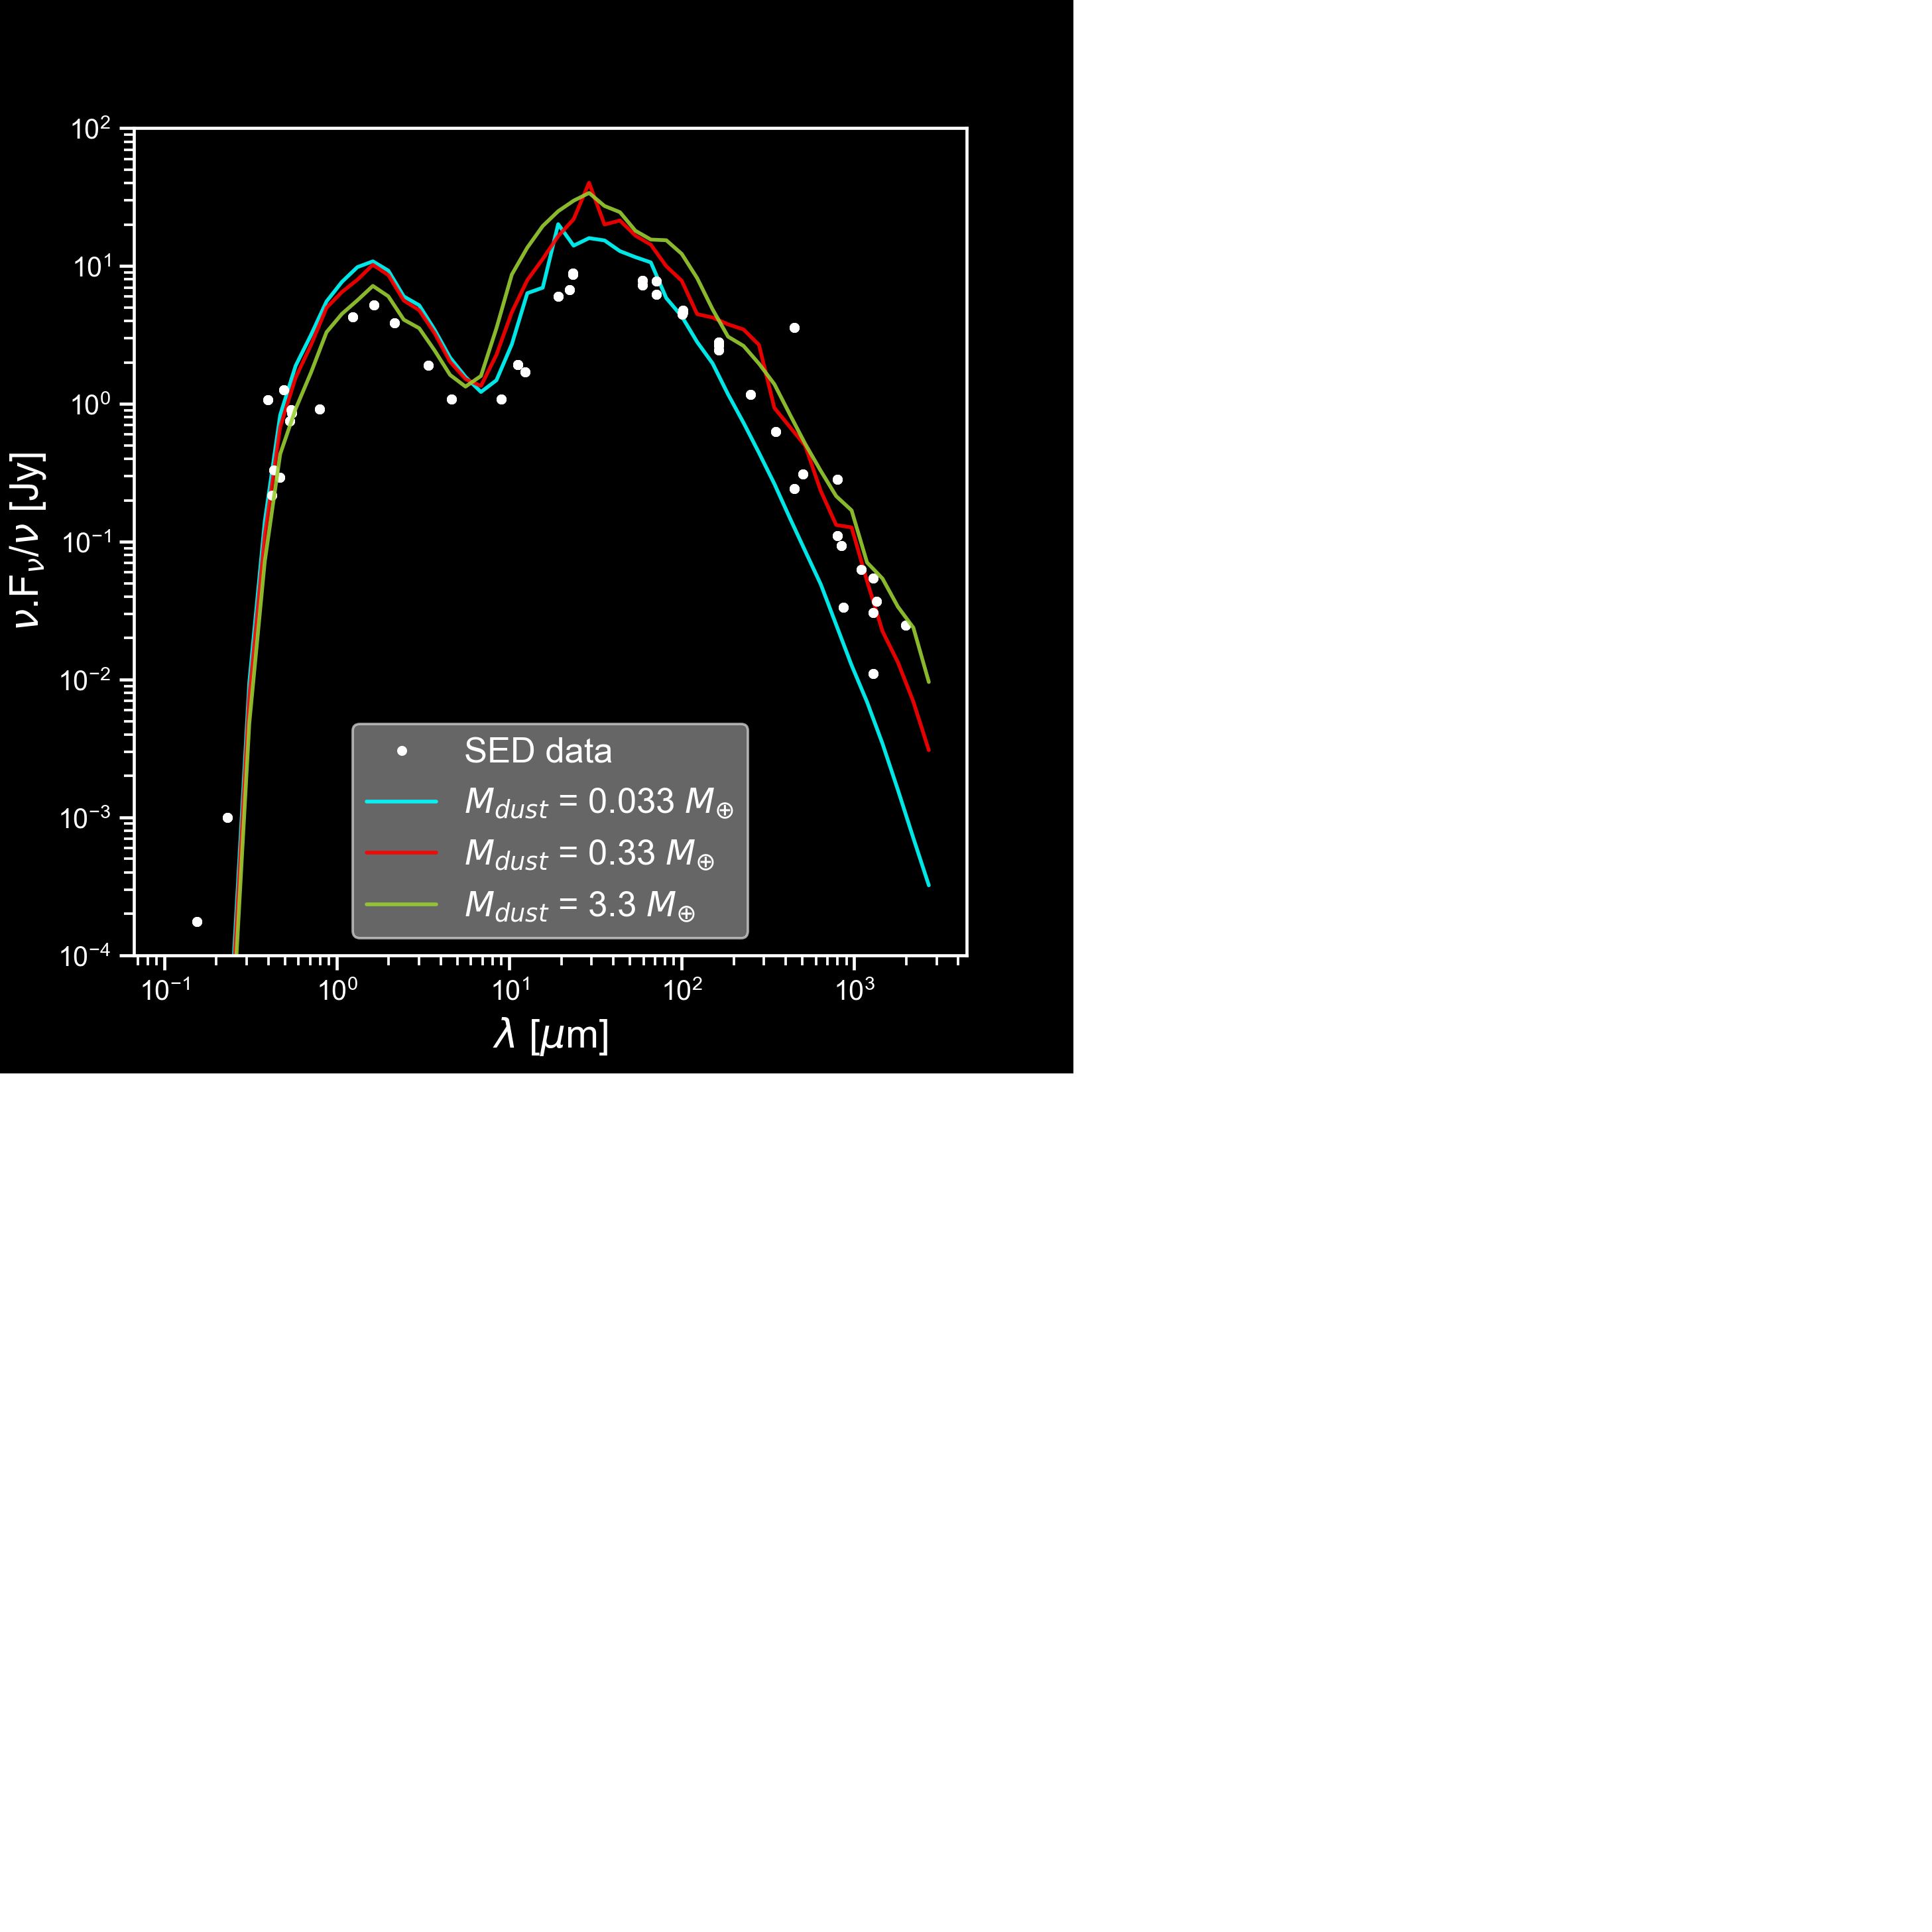

./sed_data/gm_33/sed_0.033_1000.0
./sed_data/gm_33/sed_0.33_100.0
./sed_data/gm_33/sed_3.3_10.0


In [14]:
fig, ax = plt.subplots(figsize=(6,6))
cm = ['cyan', 'red', 'yellowgreen']
ax.set_prop_cycle(color=[cm[i] for i in range(0,3,1)])
mgas = 33
wd = f'./sed_data/gm_{mgas}'
dms = [0.033,0.33,3.3]

dirs = glob(wd + '/*')
for dm in  dms:
    gdr = mgas/dm
    d = wd + f'/sed_{str(dm)}_{str(gdr)}'
#     plt.title(f'$M_{{gas}}$ = {mgas}$M_{{\oplus}}$')
    print(d)
    plot_SED(f'{d}/data_th', 0, axis=ax, contrib=False, label=f'$M_{{dust}}$ = {dm} $M_{{\oplus}}$', alpha=0.9)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg= plt.legend(by_label.values(), by_label.keys(), prop={'size': 14})
frame = leg.get_frame()
frame.set_facecolor('grey')


In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/10) for i in range(0,20,4)])
mgas = 3.3
wd = f'./sed_data/gm_{mgas}'
exclusions = ['33', '330', '3300', '33000']

dirs = glob(wd + '/*')
for d in  dirs:
    mdust, gdr = d.replace(f'{wd}/sed_', '').split('_')
    if mdust not in exclusions:
        plot_SED(f'{d}/data_th', 0, axis=ax, contrib=False, label=f'$M_{{dust}}$ = {mdust} $M_{{\oplus}}$', alpha=0.5)

plt.title(f'$M_{{gas}}$ = {mgas}$M_{{\oplus}}$')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg= plt.legend(by_label.values(), by_label.keys(), prop={'size': 12})
# frame = leg.get_frame()
# frame.set_facecolor('black')


In [ ]:
wd = 'sed_33_0_085'
plot_SED(f"./sed_data/{wd}/data_th", 0, contrib=True,  color='black', label='$M_{dust} = 3.3 M_{Earth}$')
plt.title('$M_{dust} = 3.3 M_{Earth}$')

In [14]:
# n_pts = 51
# wavelengths = 10**np.linspace(-1,1,n_pts)

# data = read_existing_fits(wavelengths*10,'./sed_fits')
# flux = np.zeros(n_pts)
# for i in range(n_pts):
#     pixel_data = data[:,:,i]
#     flux[i] = np.sum(pixel_data)

# fig = plt.figure()
# plt.plot(wavelengths, flux)
# plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Flux')




In [16]:
make_images_from_fits('./fits_z', np.arange(420,450), overwrite=True)

======= READING FITS FILE: RT_00420.fits.gz =======


AttributeError: module 'pymcfost' has no attribute 'Image'

In [8]:
make_movie('.', filename='3stars', mp4=True)

<IPython.core.display.Javascript object>


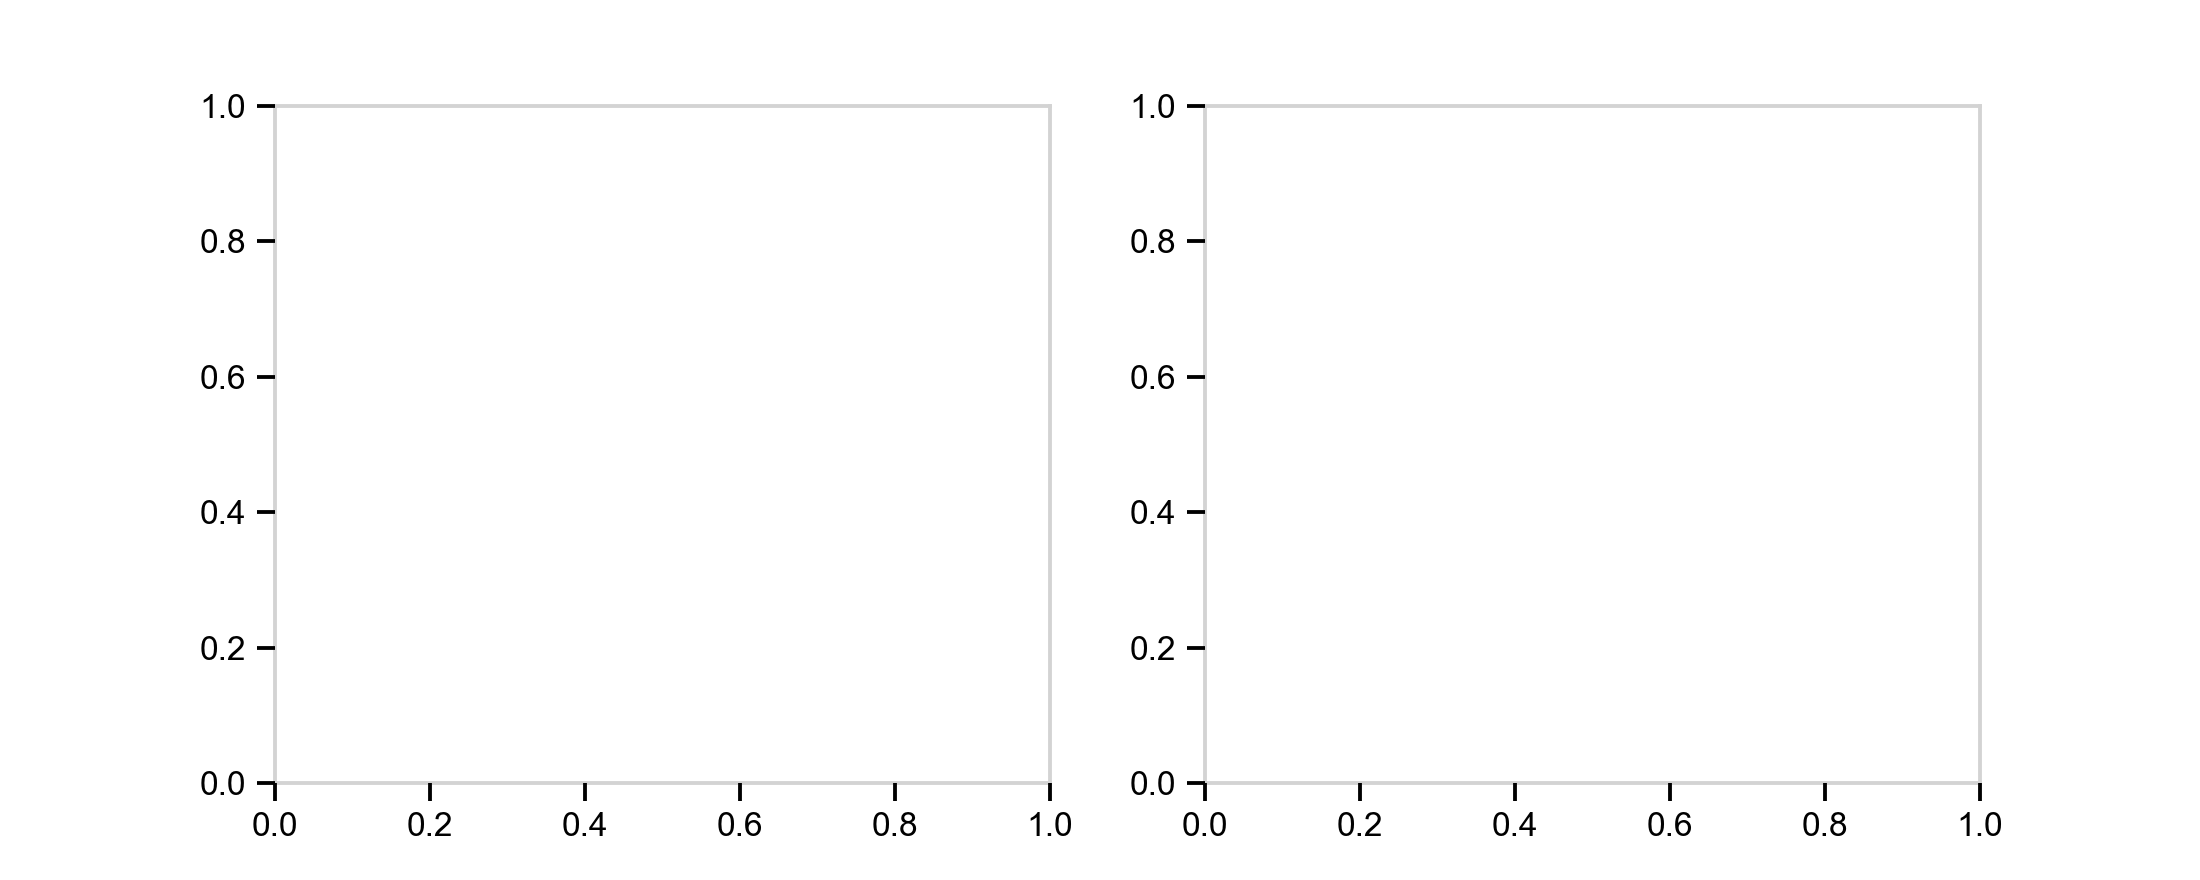

======= READING FITS FILE: RT_00400.fits.gz =======


AttributeError: module 'pymcfost' has no attribute 'Image'

In [9]:
 make_two_panel_movie_frames('./fits_3stars_1.6')

In [10]:
image_1mum = mcfost.Image("./data_3_old")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

no_ylabel = False
cbar=True
image_1mum.plot(0, ax=axes, vmax=1e-15, colorbar=cbar, no_ylabel=no_ylabel, plot_stars=True)


AttributeError: module 'pymcfost' has no attribute 'Image'

In [104]:
# B_stars_only = read_existing_fits(np.arange(0,545,1), './fits_B_only', log=False)
# hd98800_highdt = read_existing_fits(np.arange(420,1300,1), './fits_highdt', log=False)
hd98800_16 = read_existing_fits(np.arange(400,500,1), './fits_1.6', log=False)
# hd98800_bw = read_existing_fits(np.arange(400,551,1), './fits_bw', log=False)
# lowviscdisc_16 = read_existing_fits(np.arange(400,551,1), './fits_lowvisc_1.6', log=False)
# vhighviscdisc_16 = read_existing_fits(np.arange(400,551,1), './fits_vhighvisc_1.6', log=False)
# highgdr = read_existing_fits(np.arange(400,501,1), './fits_highgdr', log=False)
# highgdr2 = read_existing_fits(np.arange(400,501,1), './fits_highgdr2', log=False)
# threestars = read_existing_fits(np.arange(400,501,1), './fits_3stars_1.6', log=False)
# hd98800_3m = read_existing_fits(np.arange(400,501,1), './fits_3m', log=False)
# hd98800_30m = read_existing_fits(np.arange(400,501,1), './fits_30m', log=False)


<IPython.core.display.Javascript object>


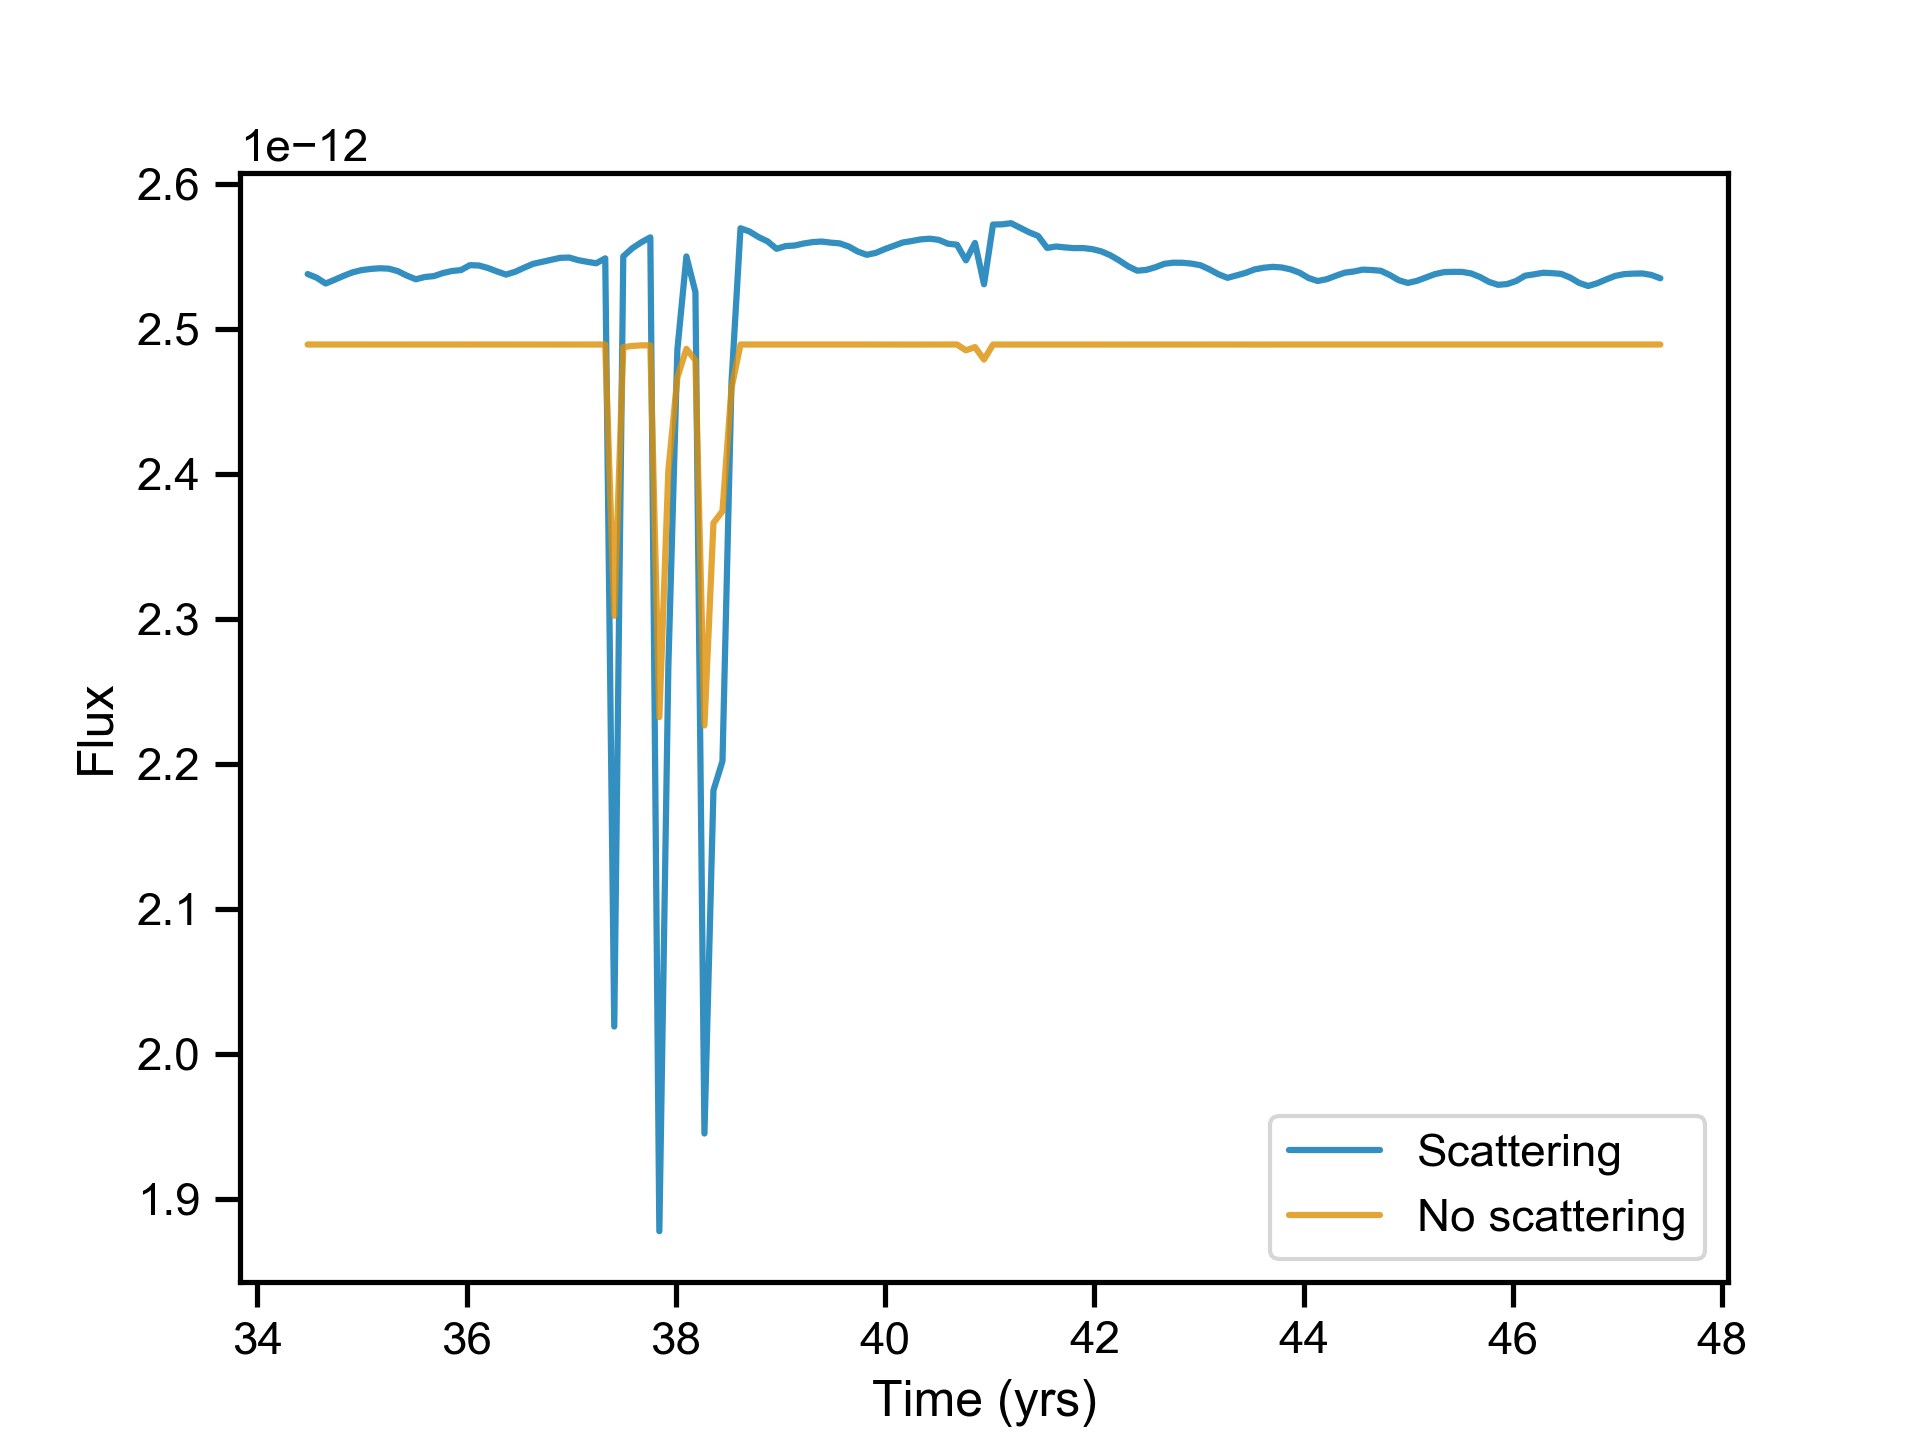

In [16]:
data1 = read_existing_fits(np.arange(400,551,1), './fits_1e9')
data2 = read_existing_fits(np.arange(400,551,1), './fits_no_scatt')
generate_lightcurve([data1,data2], start_time=400*dt, moving_avg_width=0, normalise=False, labels=['Scattering', 'No scattering'])

<IPython.core.display.Javascript object>


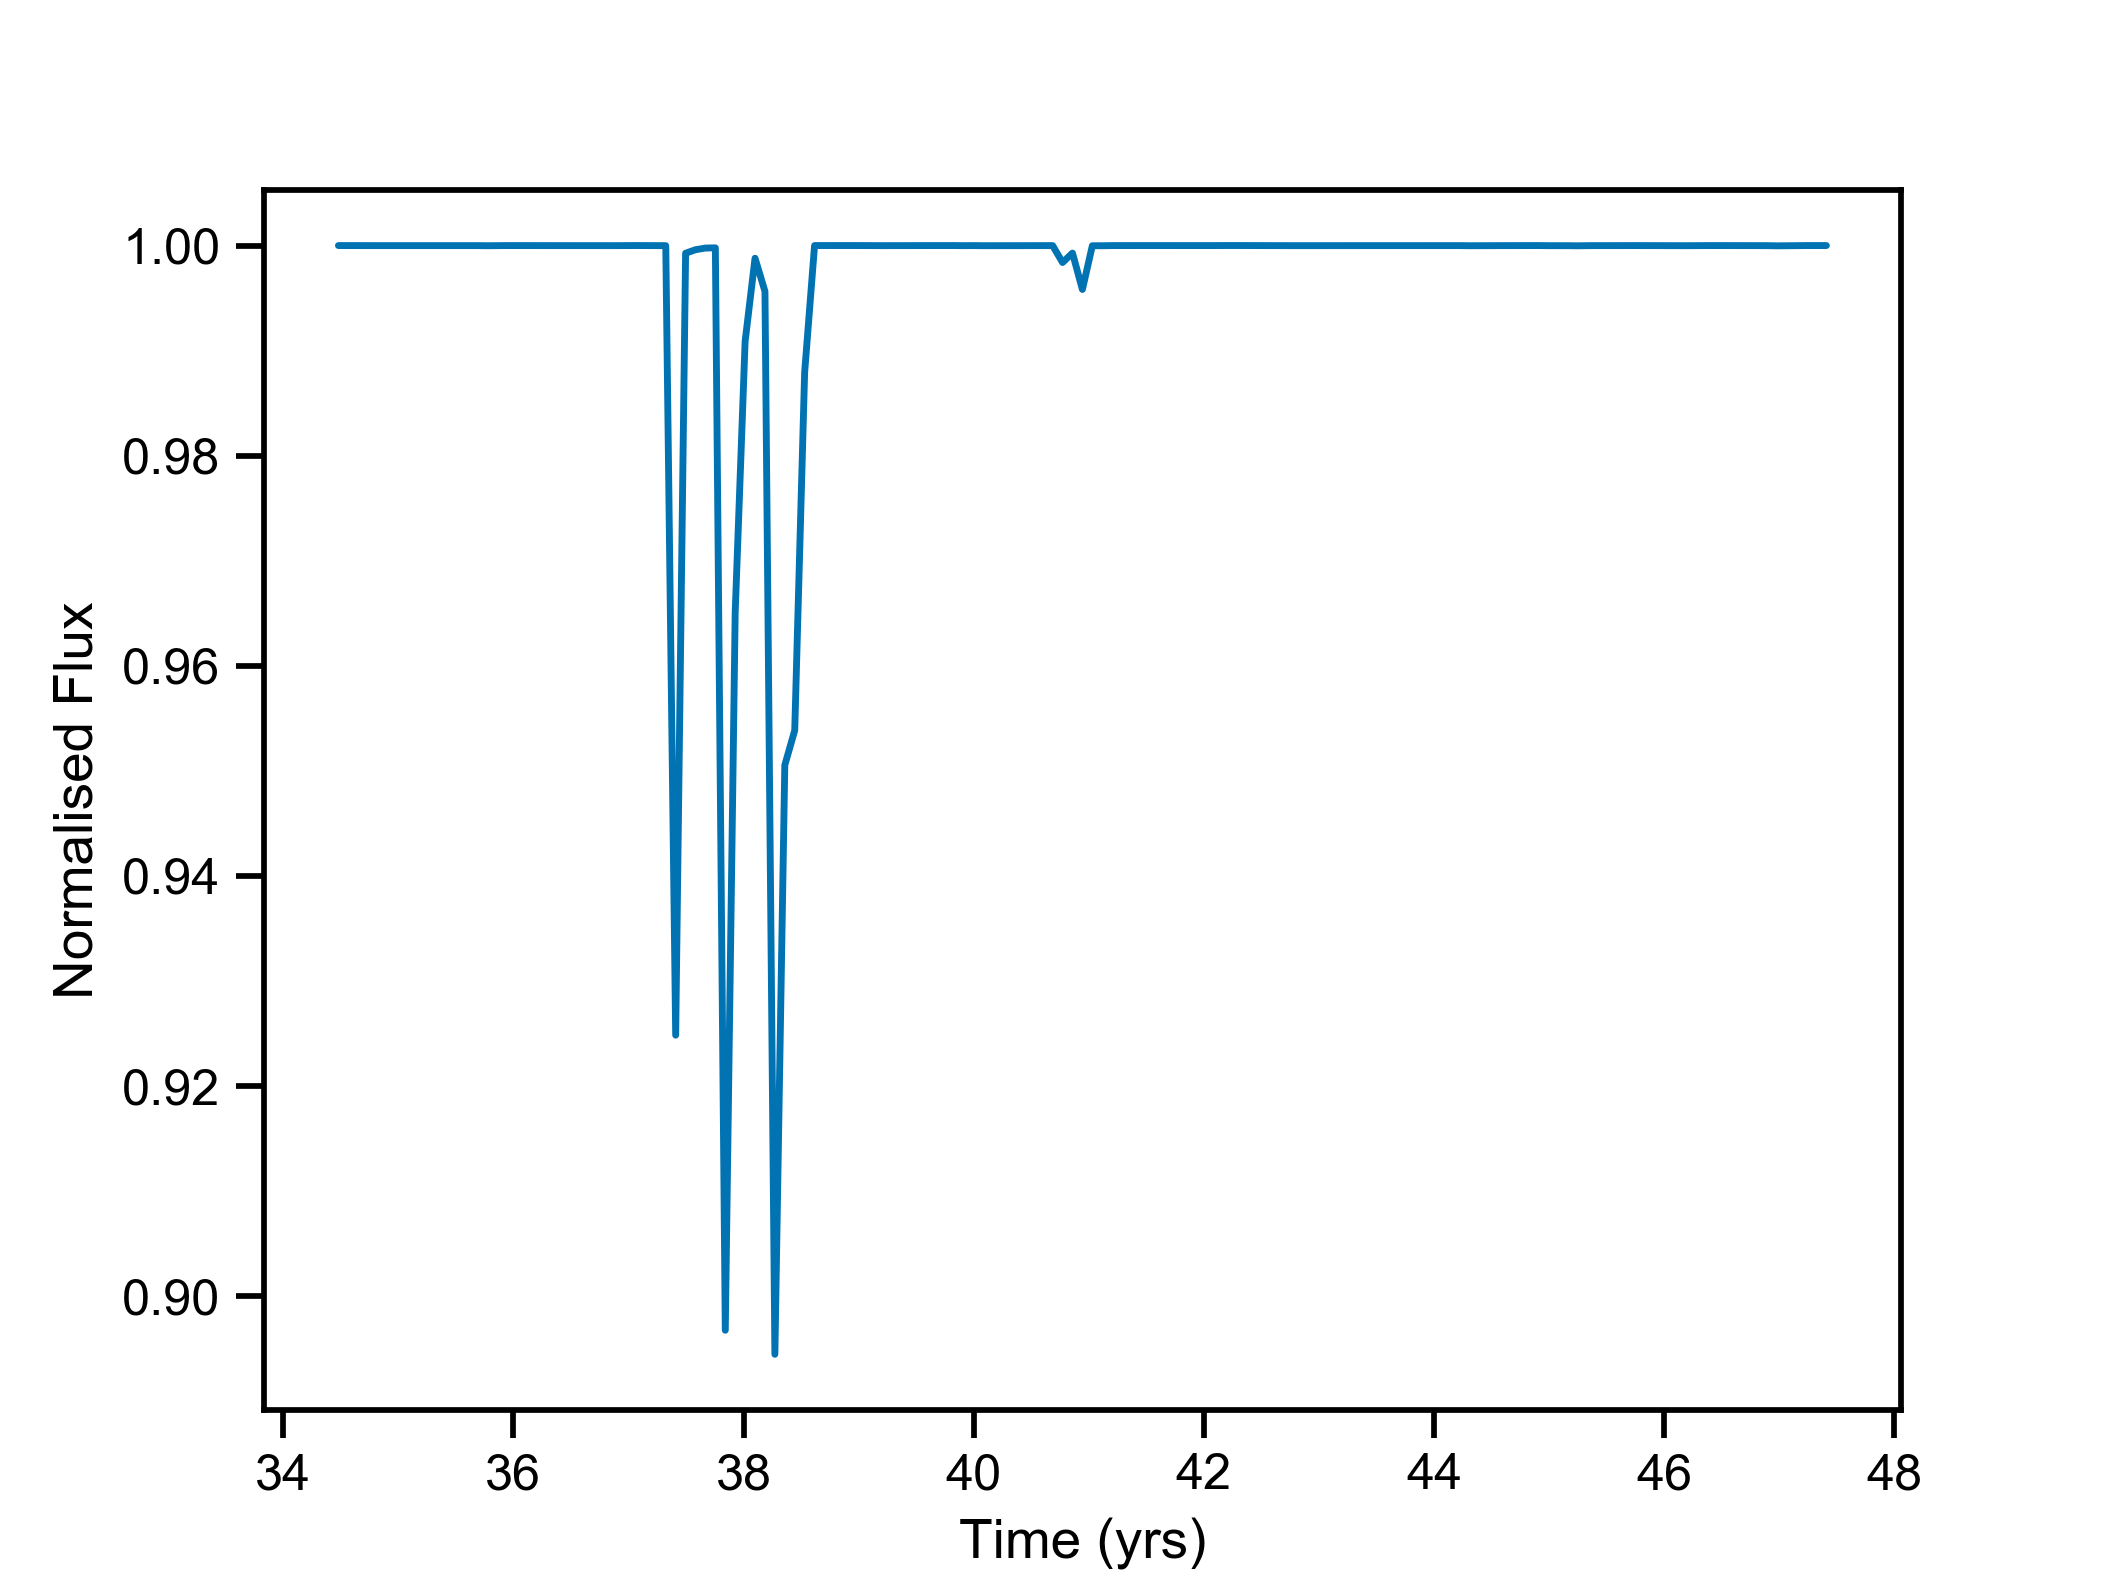

In [6]:
data = read_existing_fits(np.arange(400,551,1), './fits_no_scatt')
generate_lightcurve(data, start_time=400*dt, moving_avg_width=0, normalise=True)

In [9]:
# Cut out B stars to have A stars only + disc

# from copy import deepcopy

# c = 200
# r = 4

# data = deepcopy(hd98800)
# data[c-r:c+r,c-r:c+r][data[c-r:c+r,c-r:c+r] > 1E-15] = 0.0


# make_gif(logged_data, 'A_stars_only.gif')

generate_lightcurve(data, start_time=400*dt, moving_avg_width=10, normalise=False)

<IPython.core.display.Javascript object>


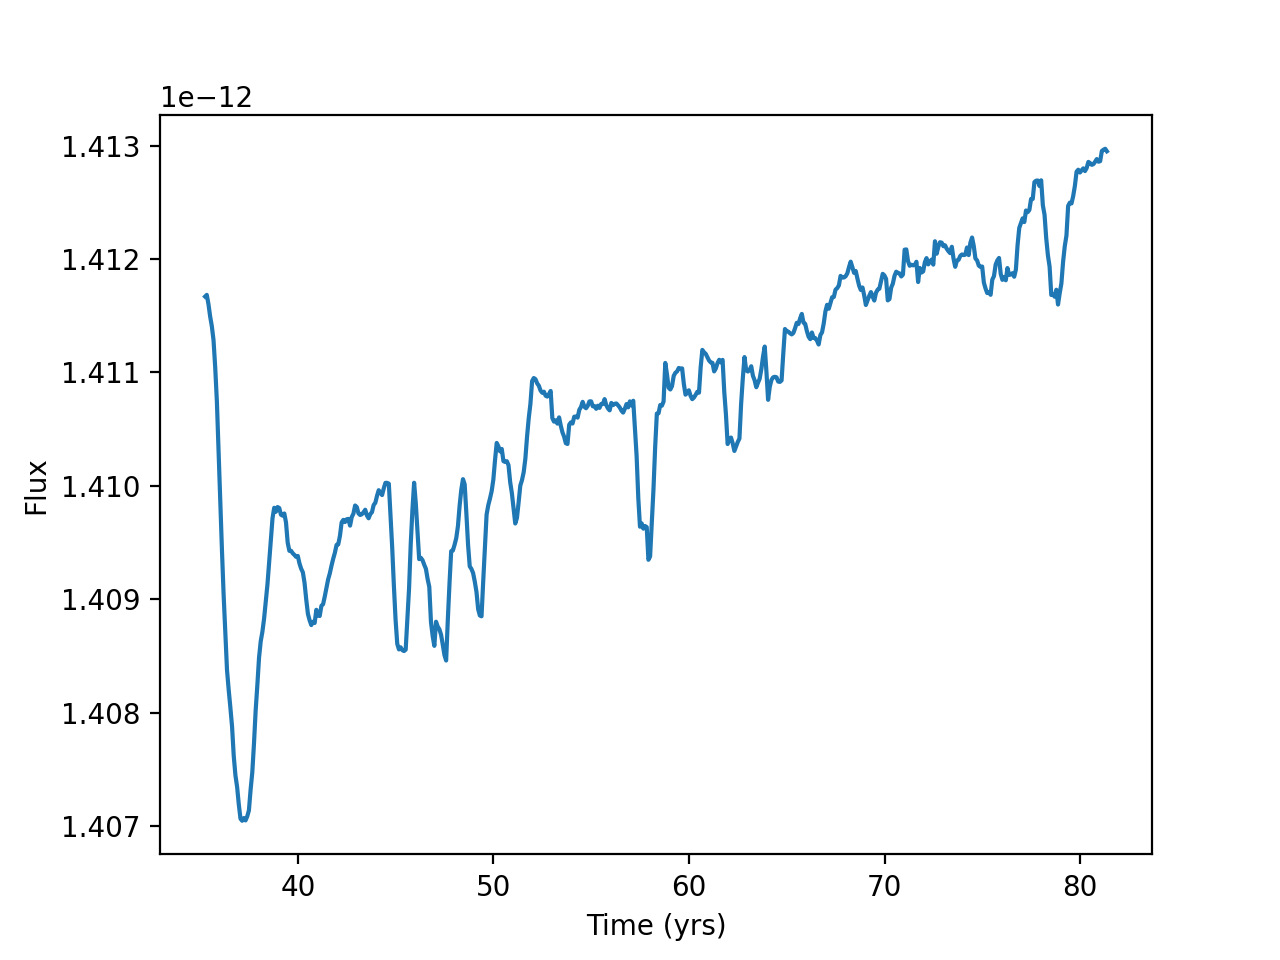

In [5]:
generate_lightcurve(B_stars_only, start_time=400*dt, moving_avg_width=10, normalise=False)

<IPython.core.display.Javascript object>


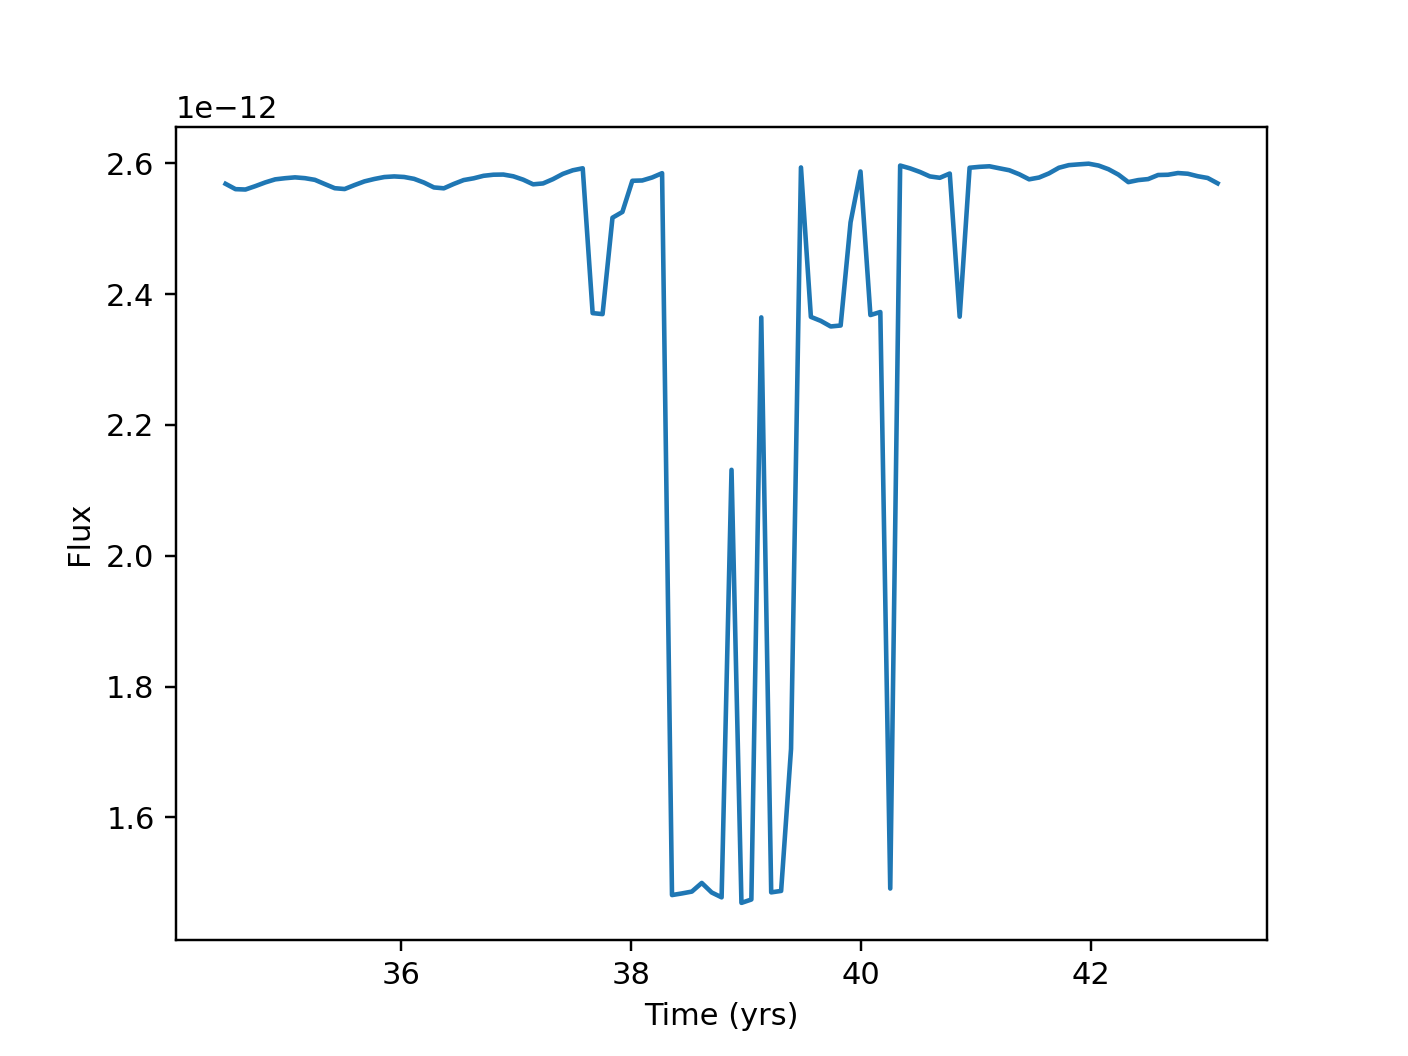

In [5]:
generate_lightcurve(hd98800_3m, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


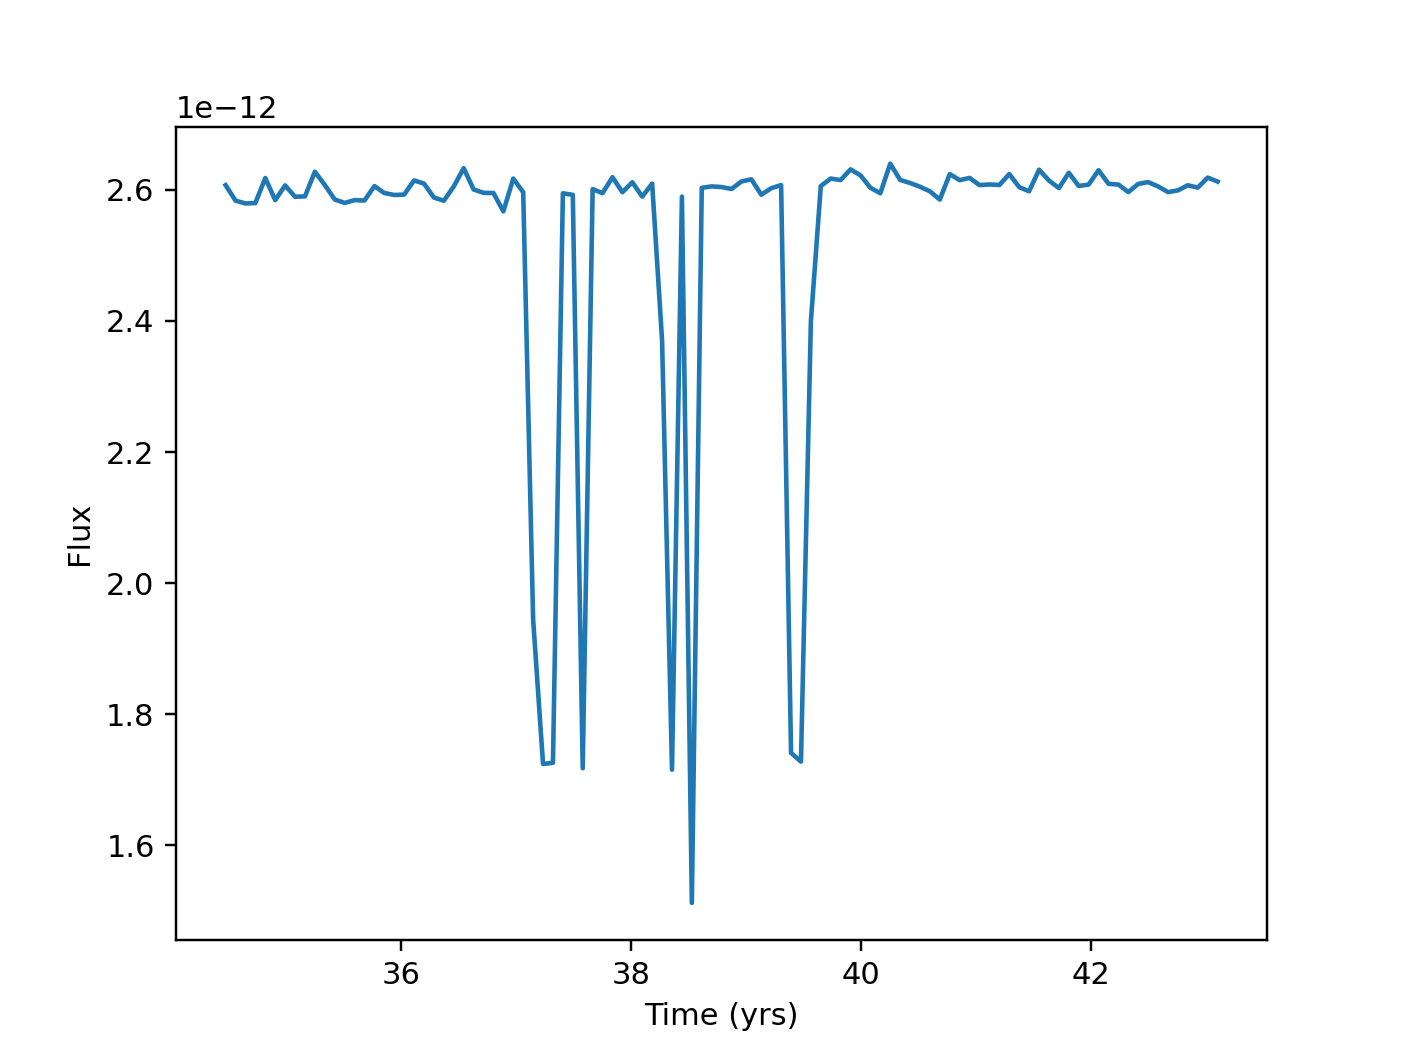

In [6]:
generate_lightcurve(hd98800_30m, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


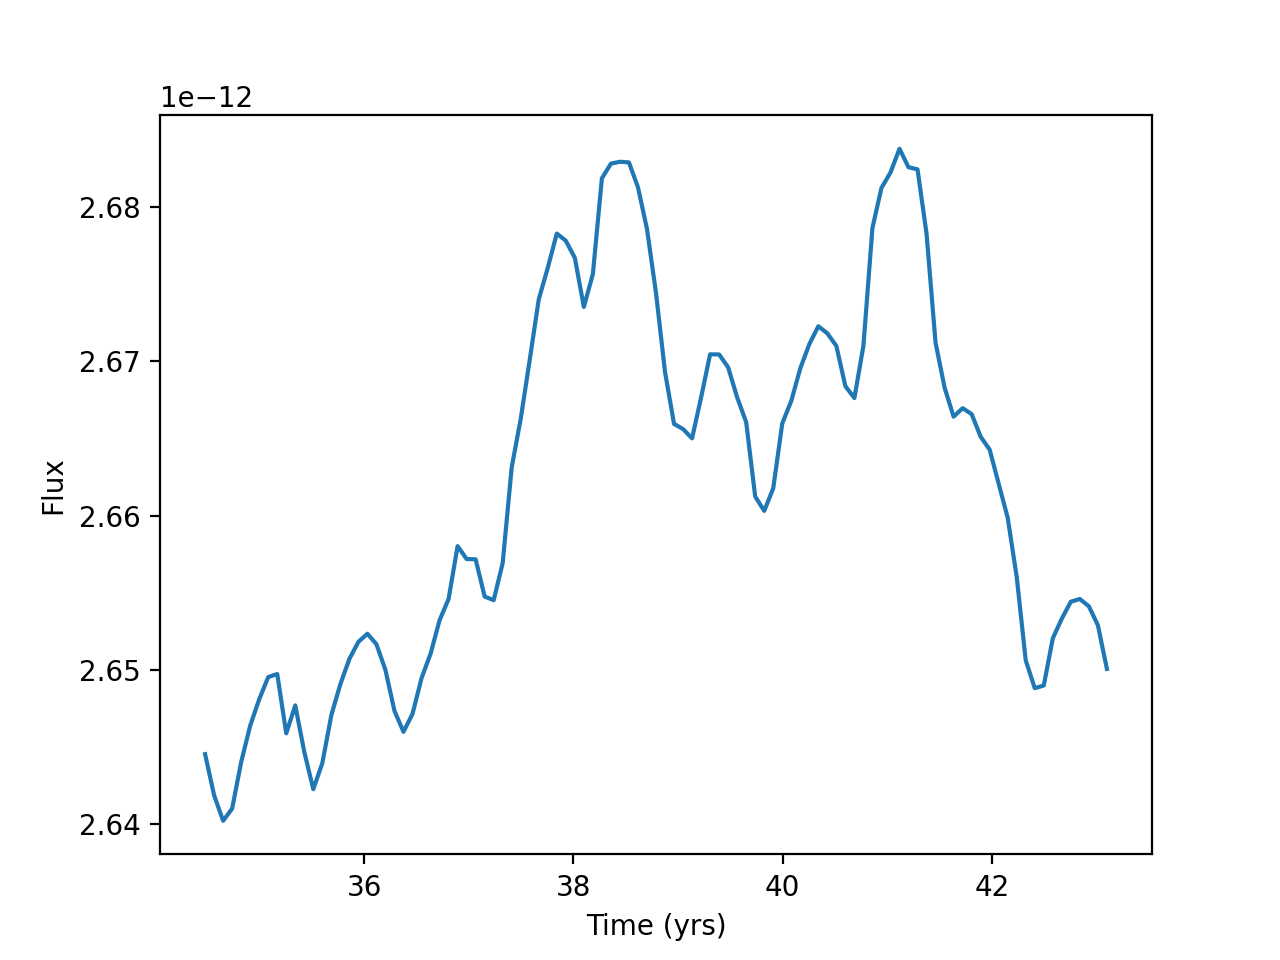

In [12]:
generate_lightcurve(threestars, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


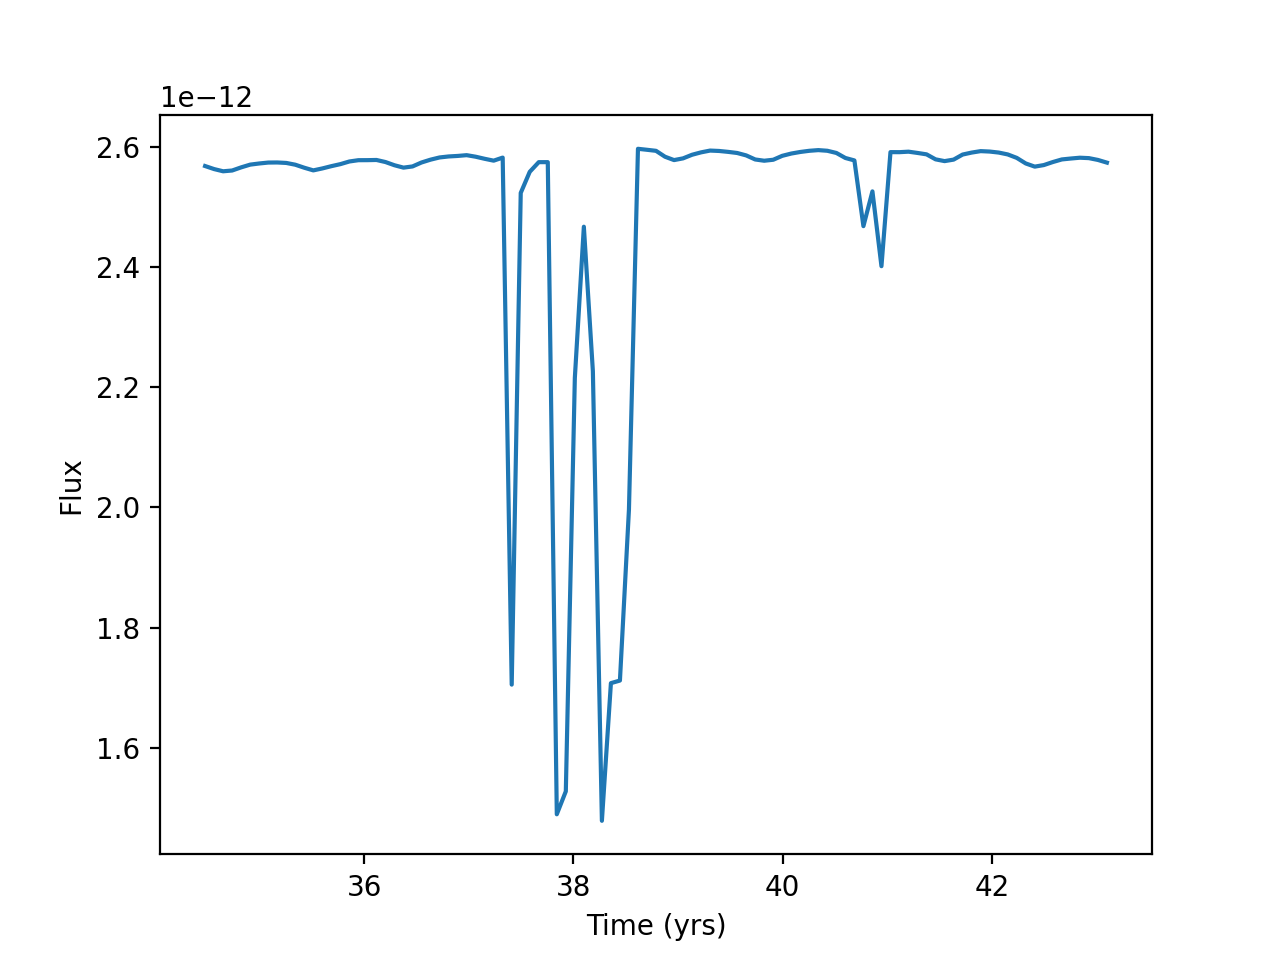

In [25]:
generate_lightcurve(highgdr, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


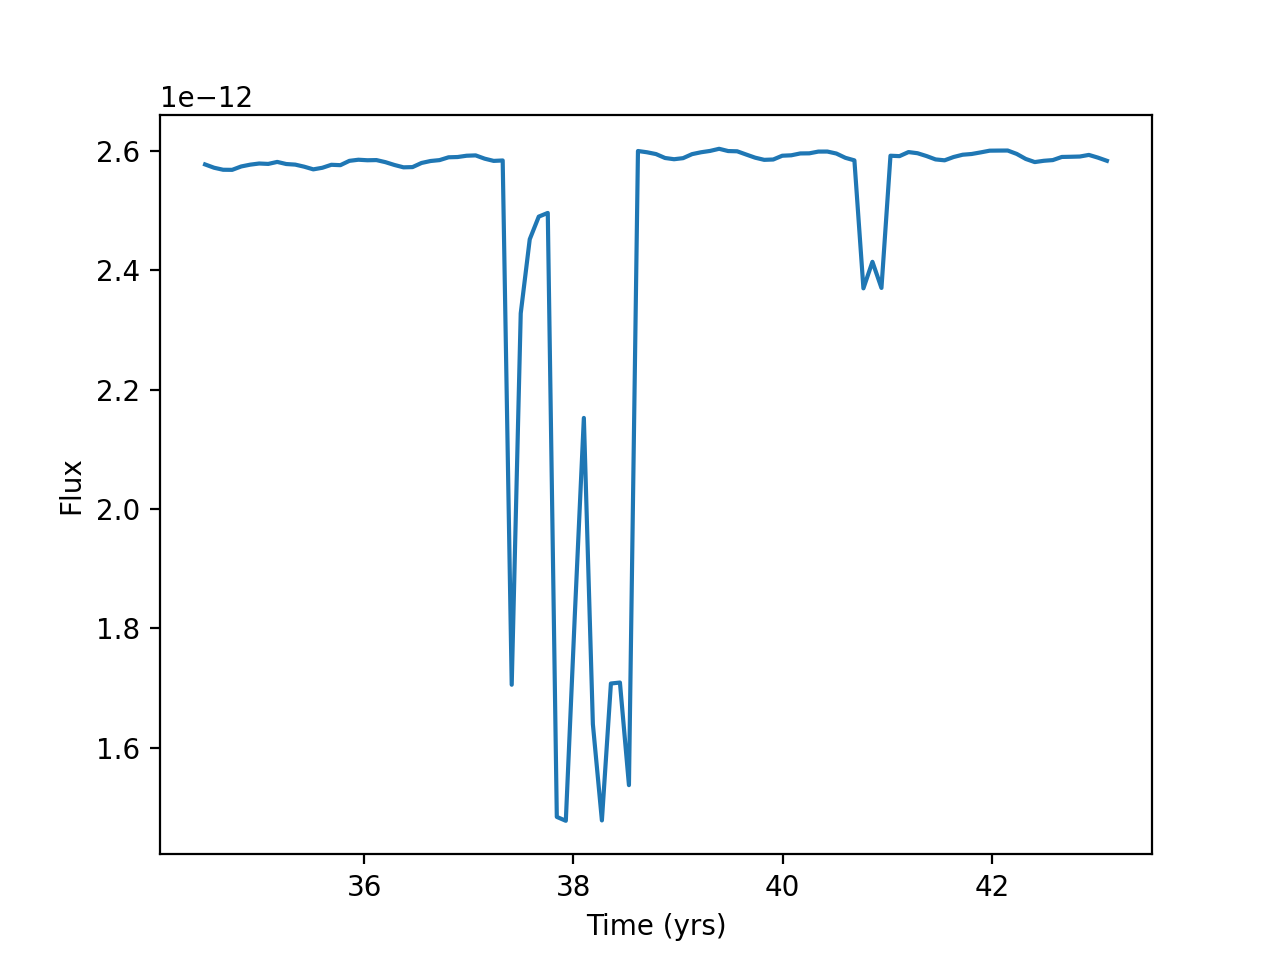

In [7]:
generate_lightcurve(highgdr2, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


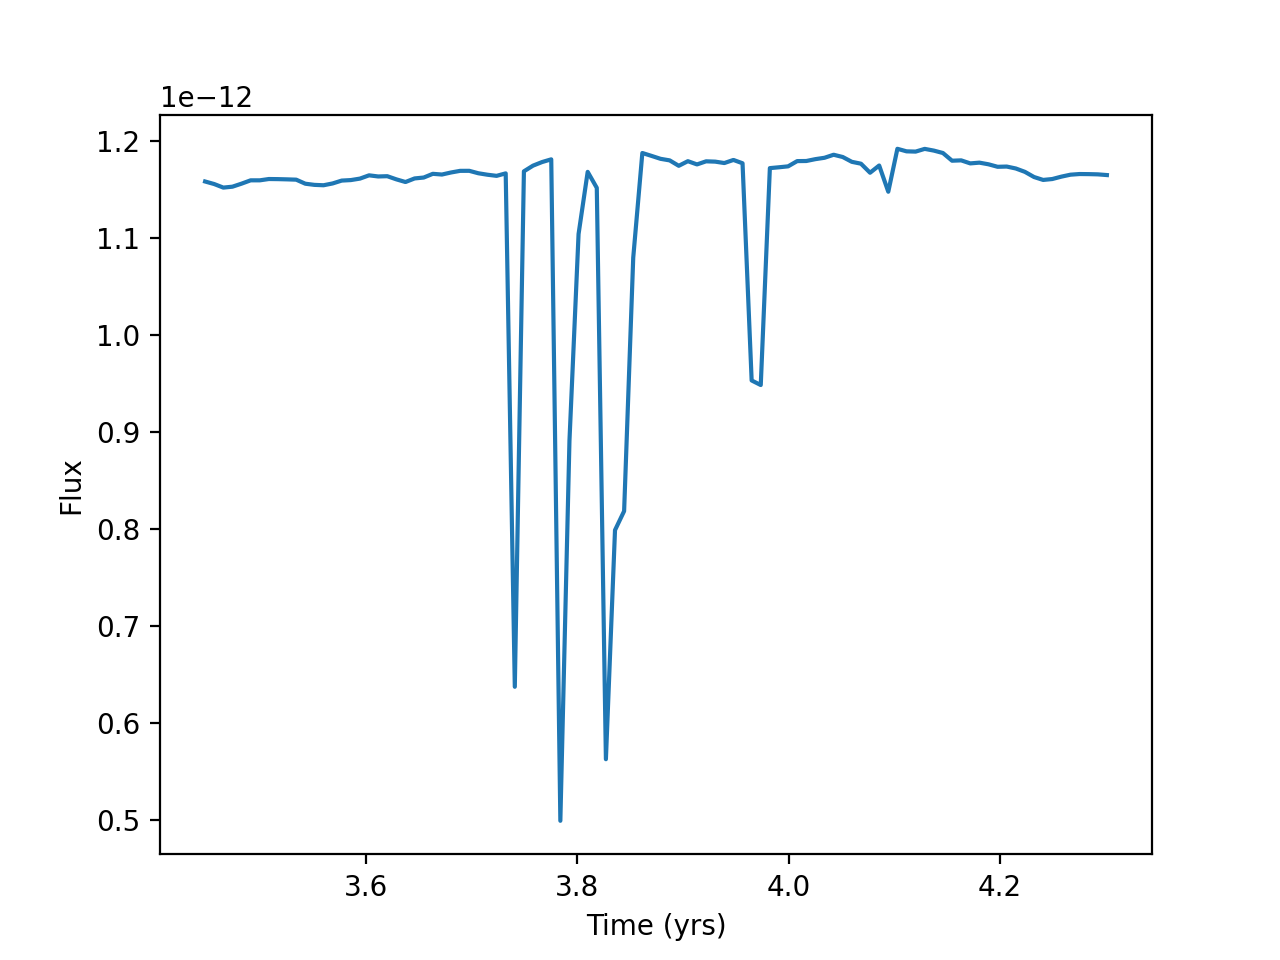

In [18]:
generate_lightcurve(data, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


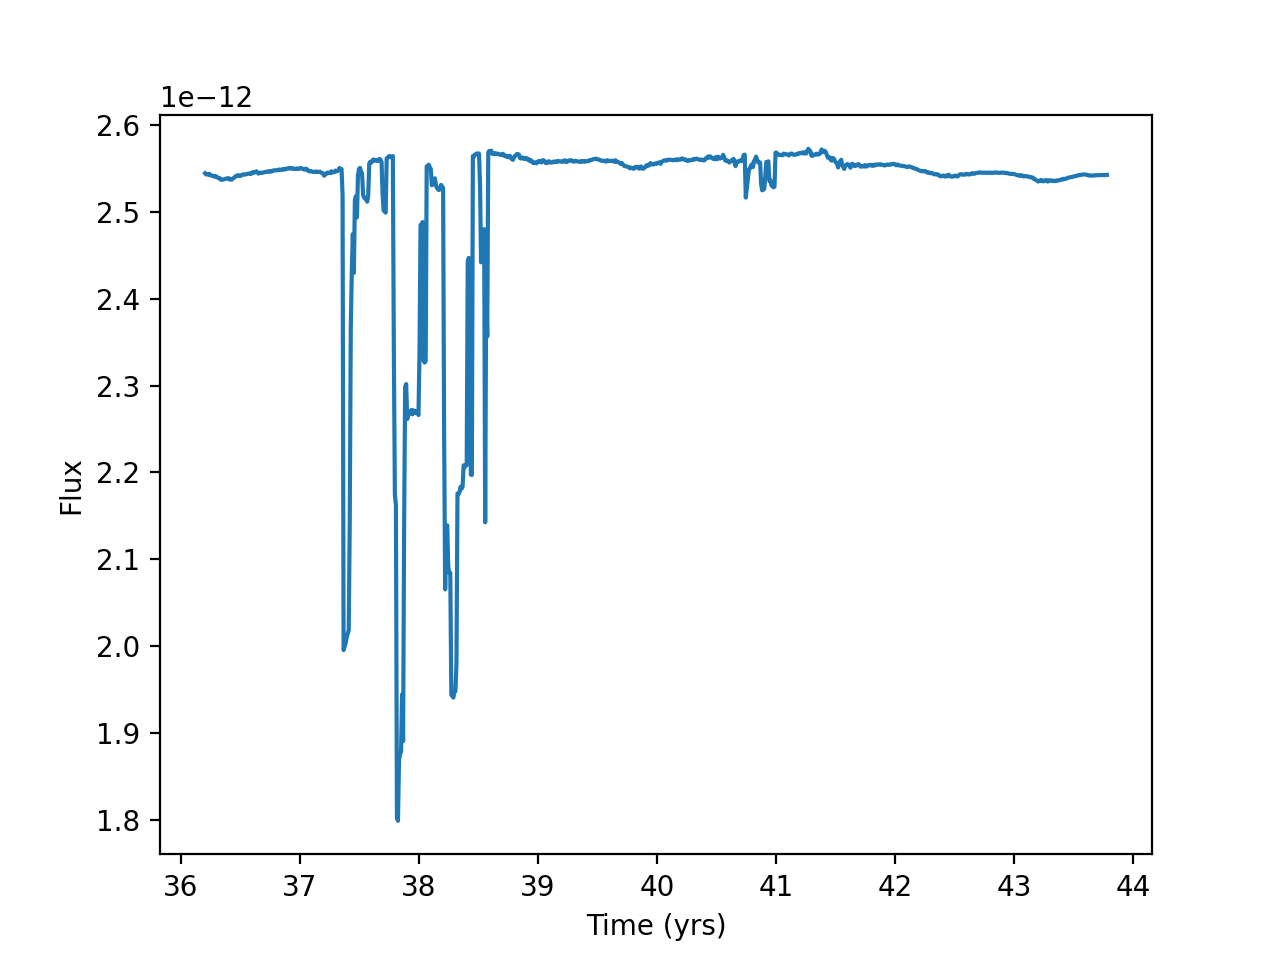

In [19]:
generate_lightcurve(hd98800_highdt, start_time=420*10*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


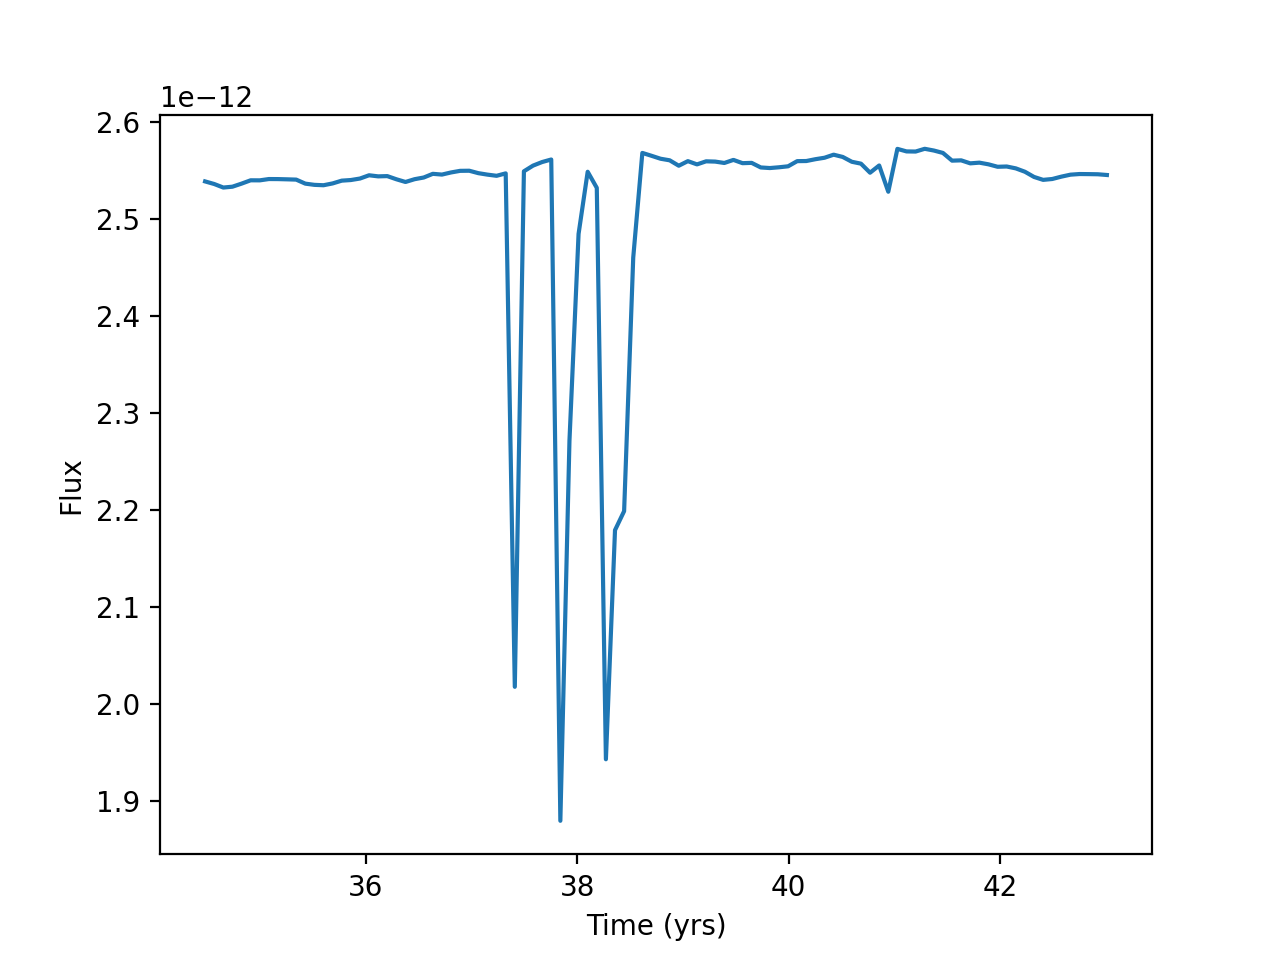

In [9]:
generate_lightcurve(hd98800_16, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


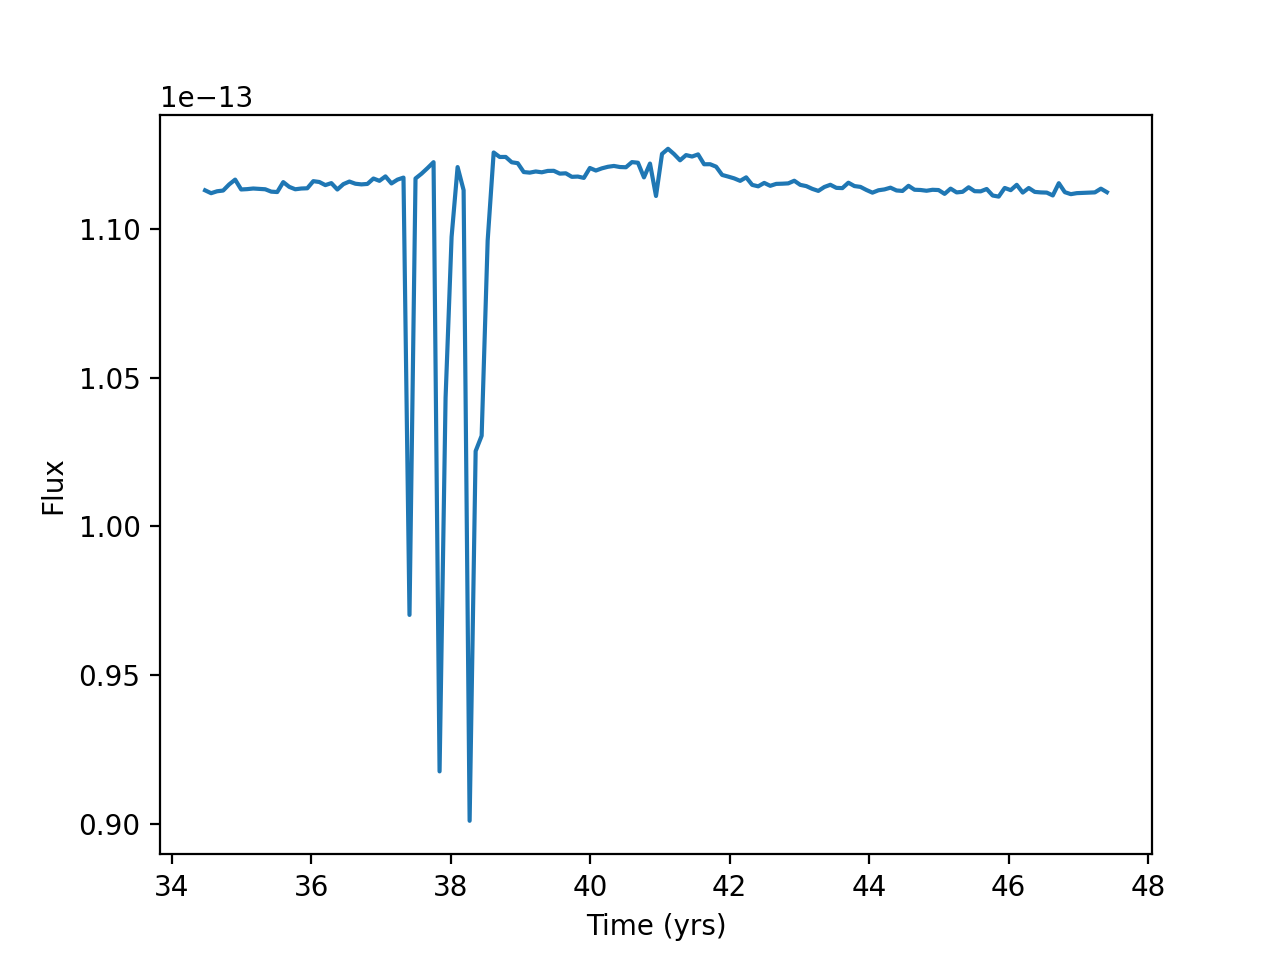

In [8]:
generate_lightcurve(hd98800_5, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


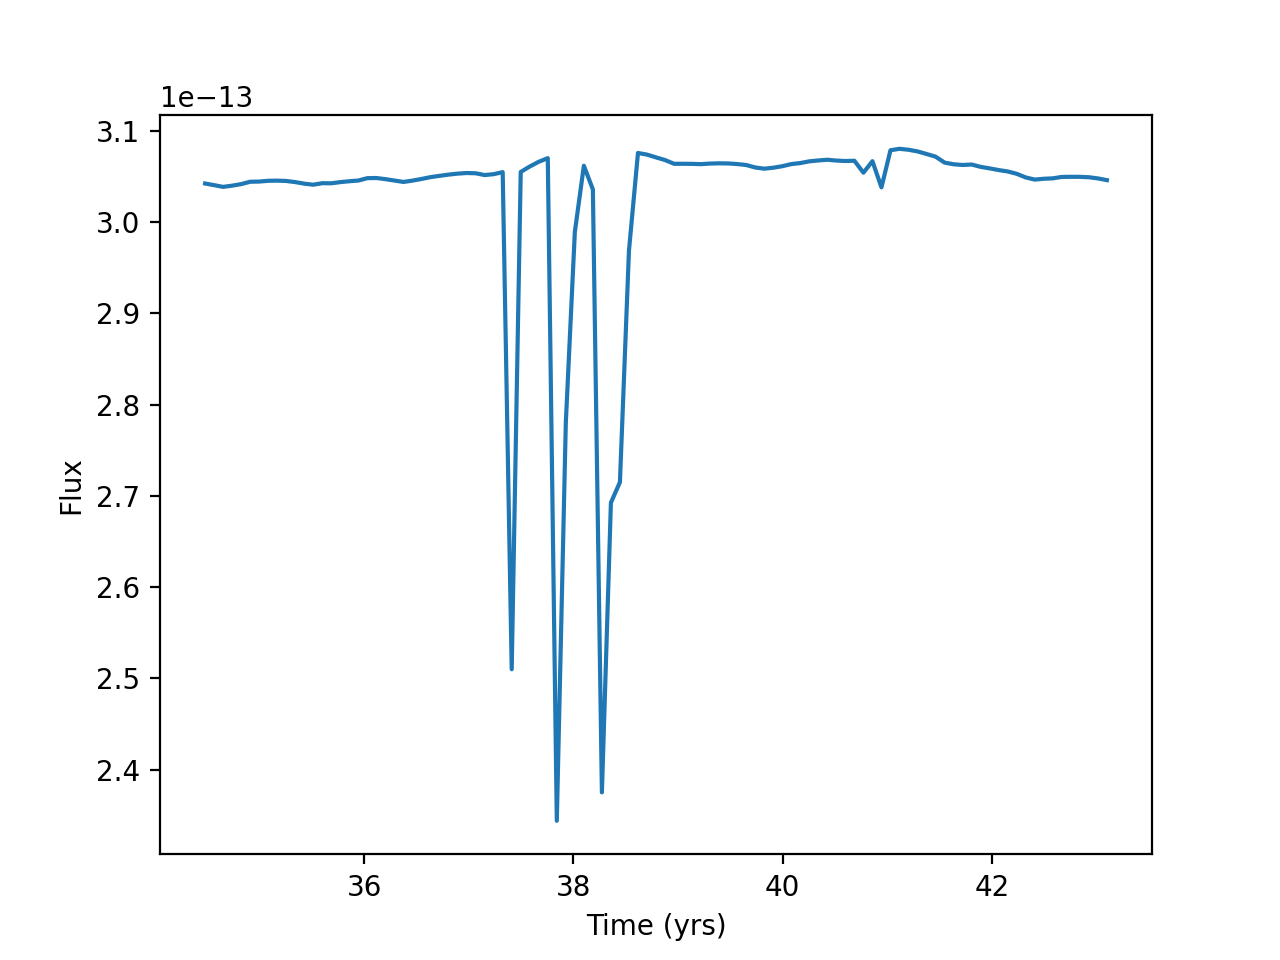

In [18]:
generate_lightcurve(hd98800_3, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


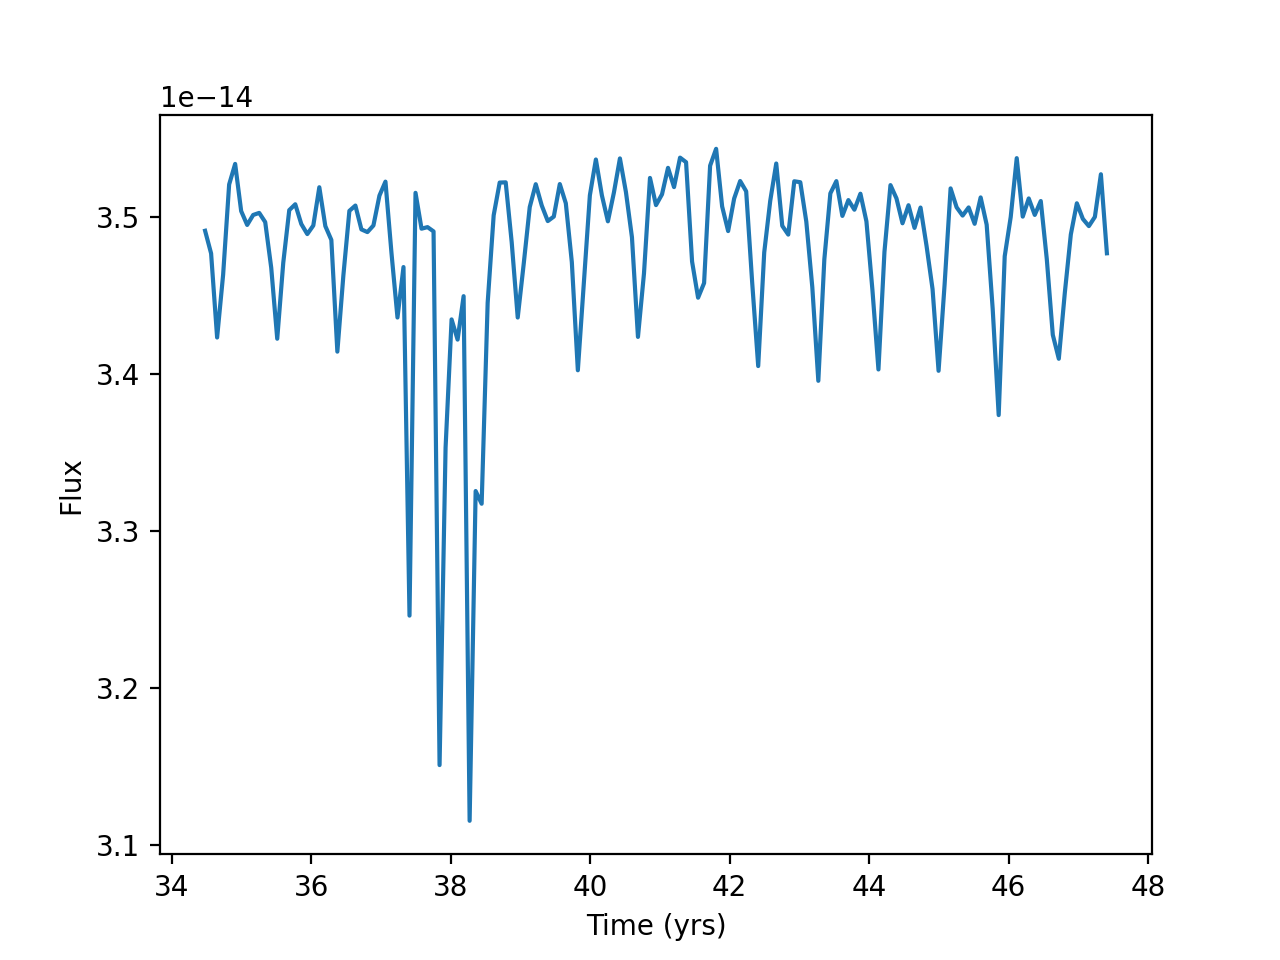

In [7]:
generate_lightcurve(hd98800_10, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


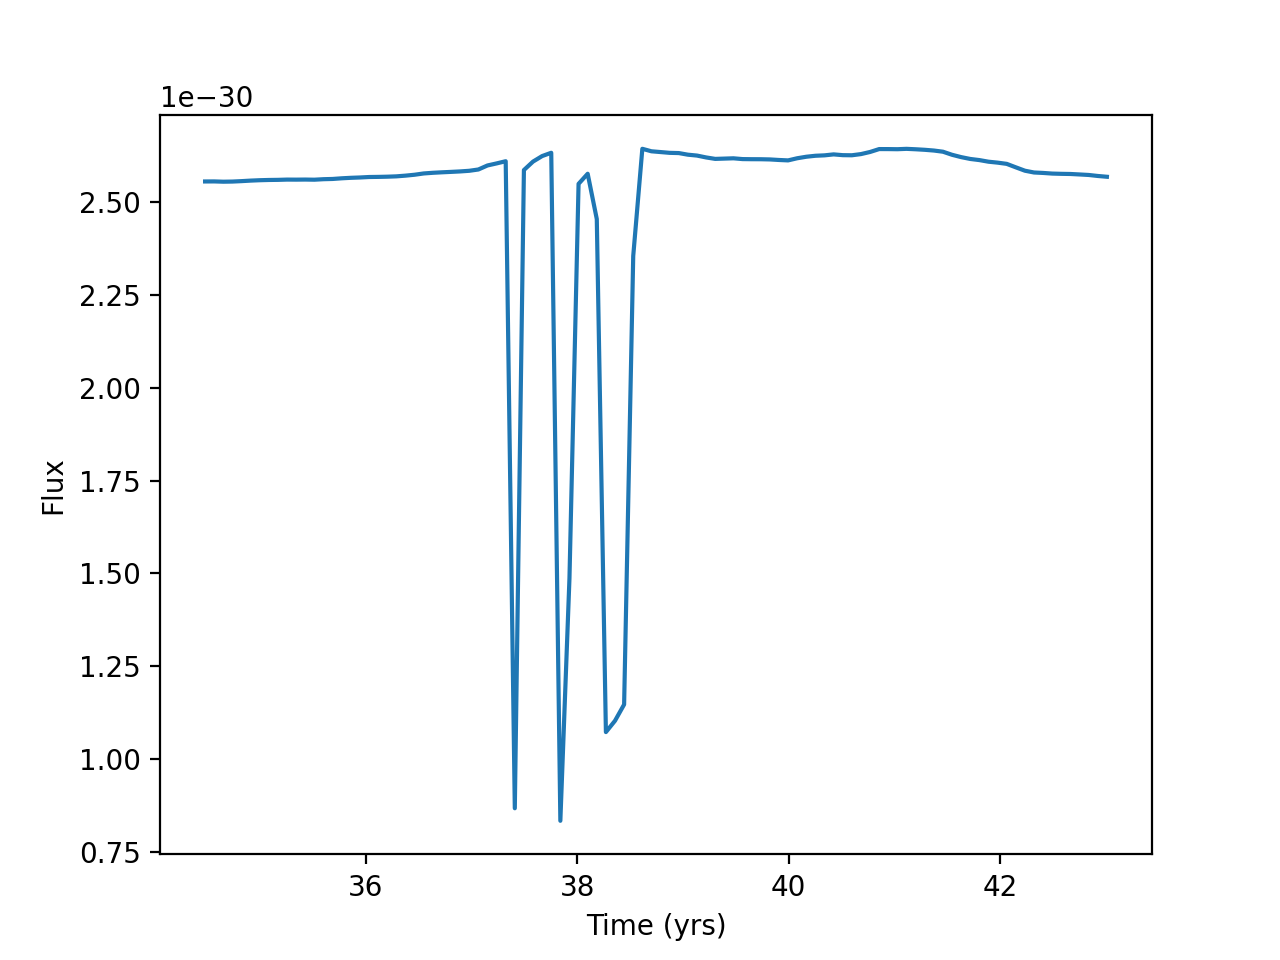

In [5]:
generate_lightcurve(hd98800_01, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


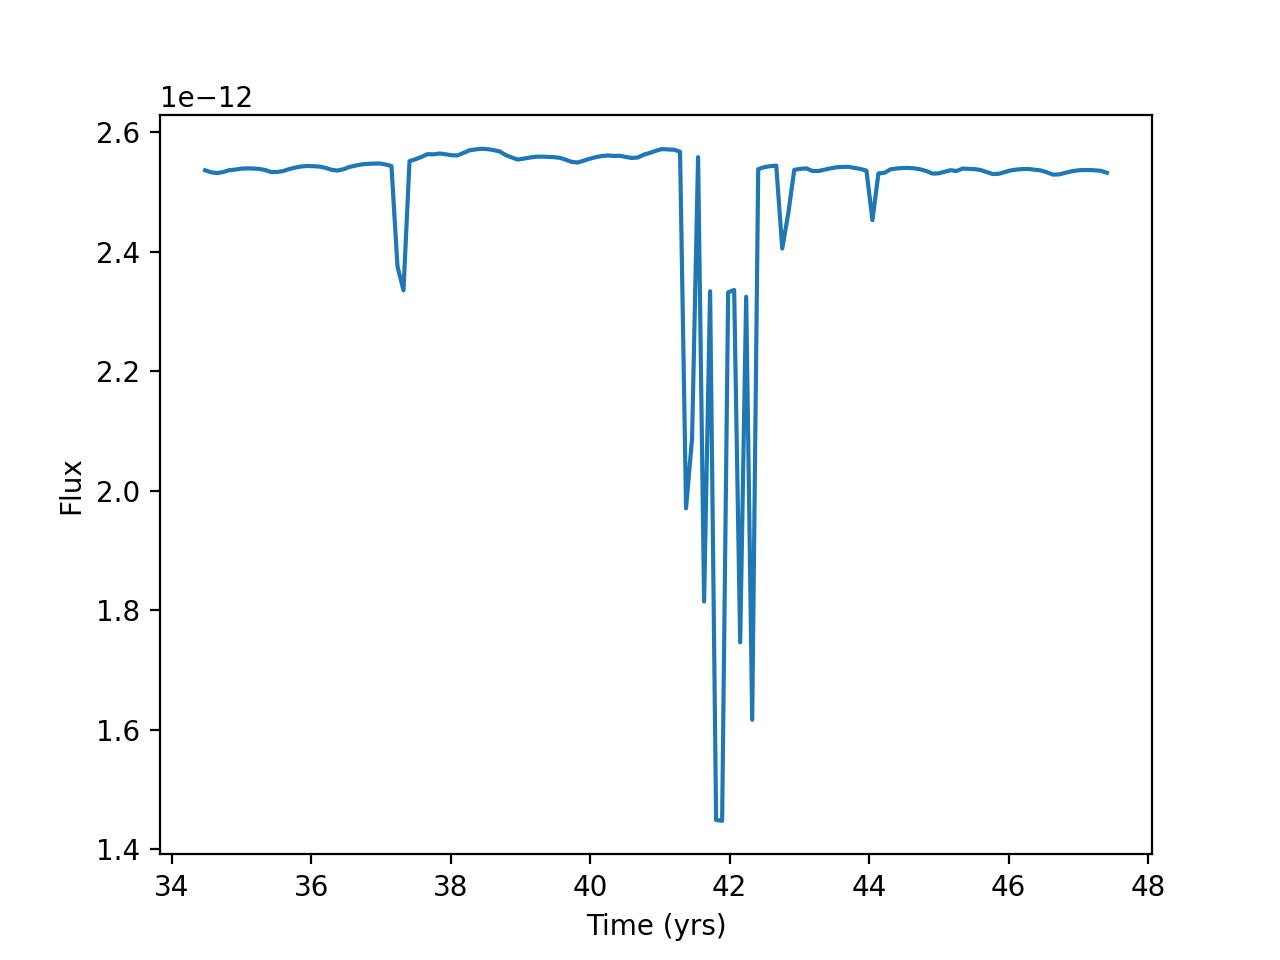

In [5]:
generate_lightcurve(hd98800_bw, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


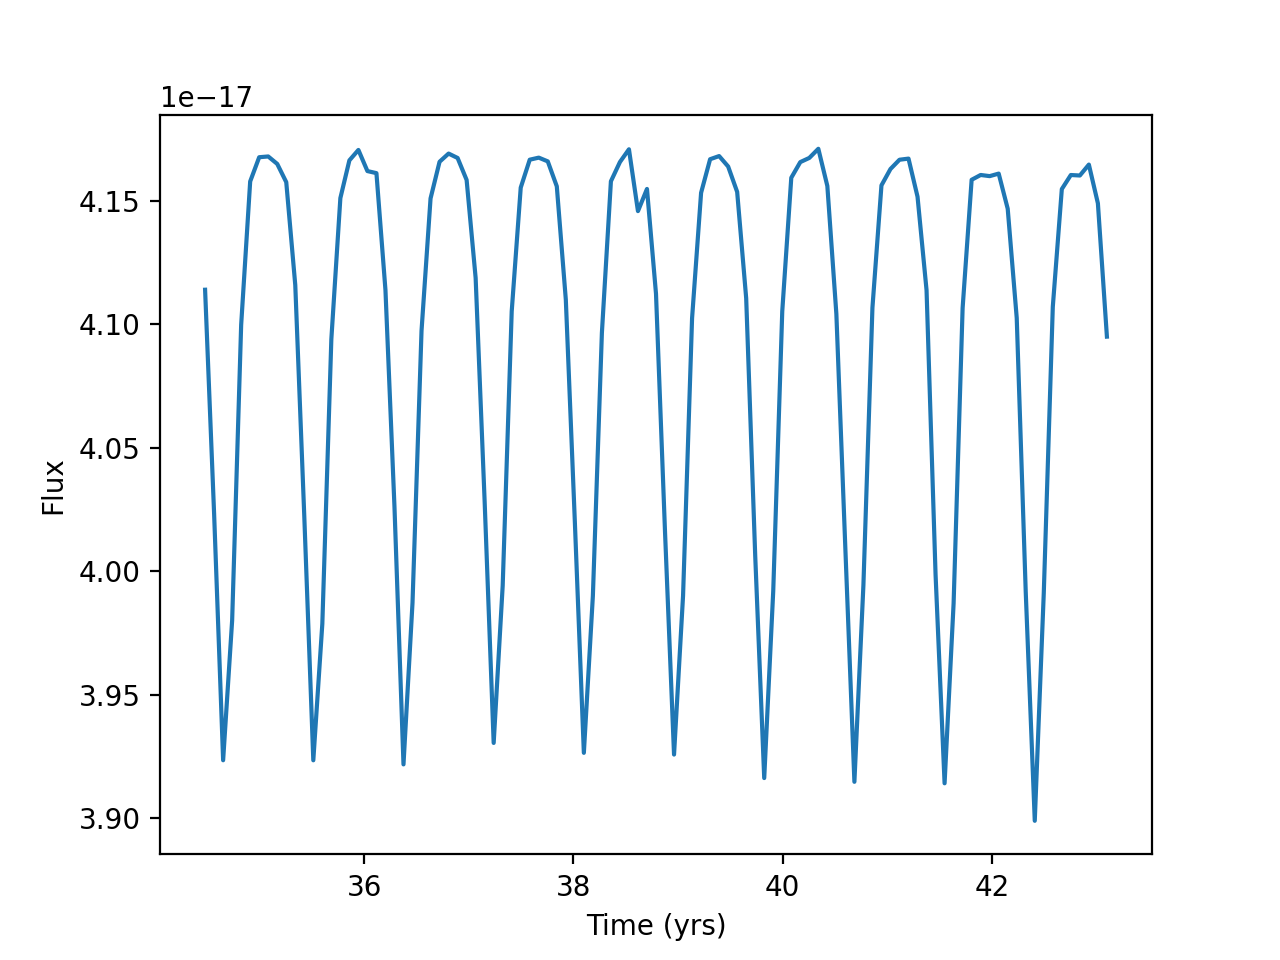

In [7]:
generate_lightcurve(hd98800_300, start_time=400*dt, moving_avg_width=0, normalise=False)

<IPython.core.display.Javascript object>


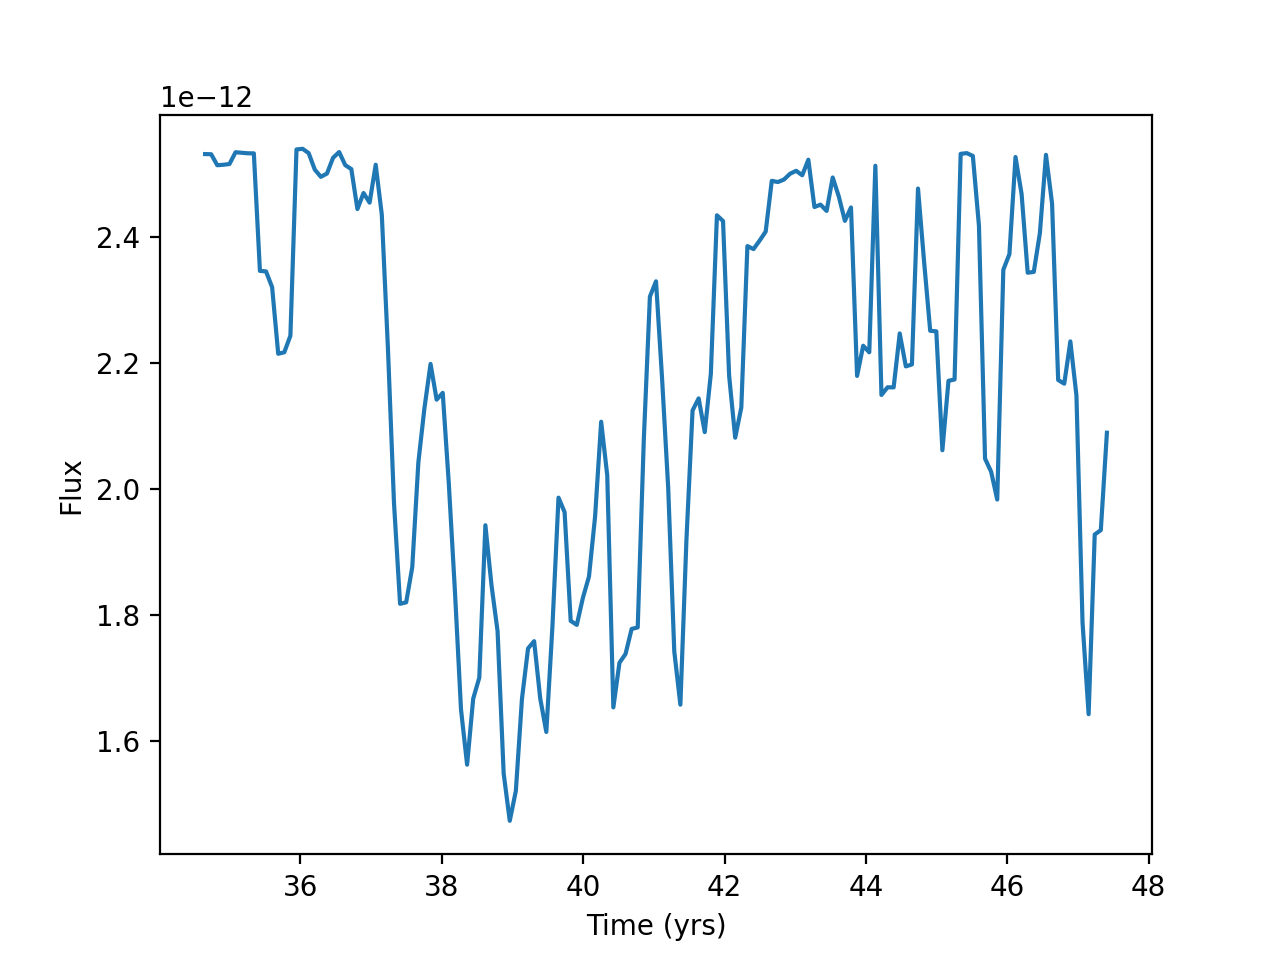

In [12]:
generate_lightcurve(lowviscdisc_16, start_time=400*dt, moving_avg_width=3, normalise=False)

<IPython.core.display.Javascript object>


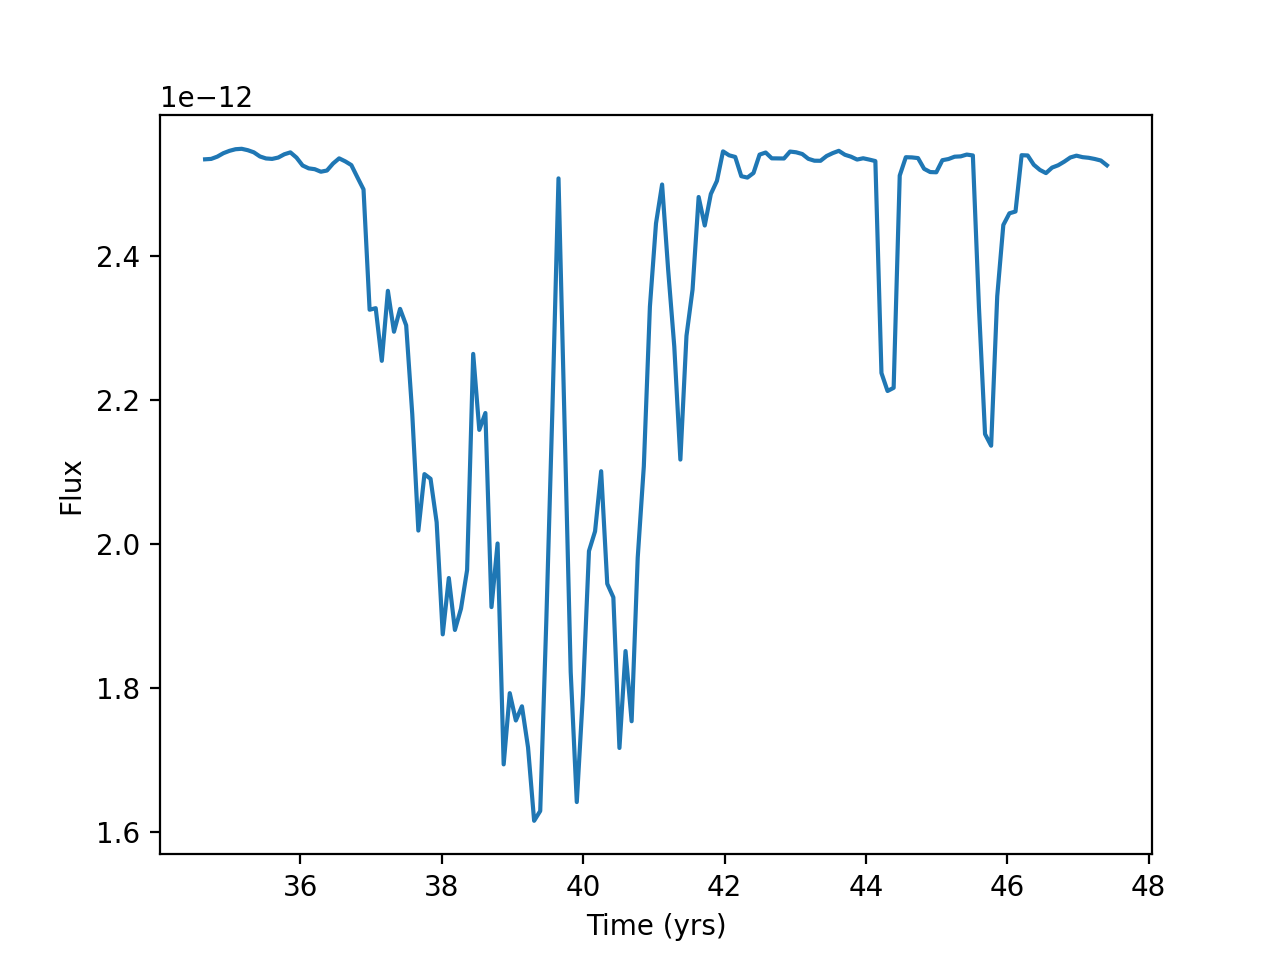

In [11]:
generate_lightcurve(vhighviscdisc_16, start_time=400*dt, moving_avg_width=3, normalise=False)

In [10]:
# Generate splash png files (if number of dumpfiles exceeds splash limit)

import os
import os.path

files = sorted(glob('disc_2_stars_copy/disc_?????'))[0:21800:10]

for f in files:
  idx = f.split('/')[-1].split('_')[-1]
  output = 'splash_{}.png'.format(idx)
  if not os.path.isfile(output):
    os.system('~/splash/bin/splash -f phantom {} --sink=2 -x 2 -y 1 -r 6 -dev {}'.format(f, output))

<IPython.core.display.Javascript object>


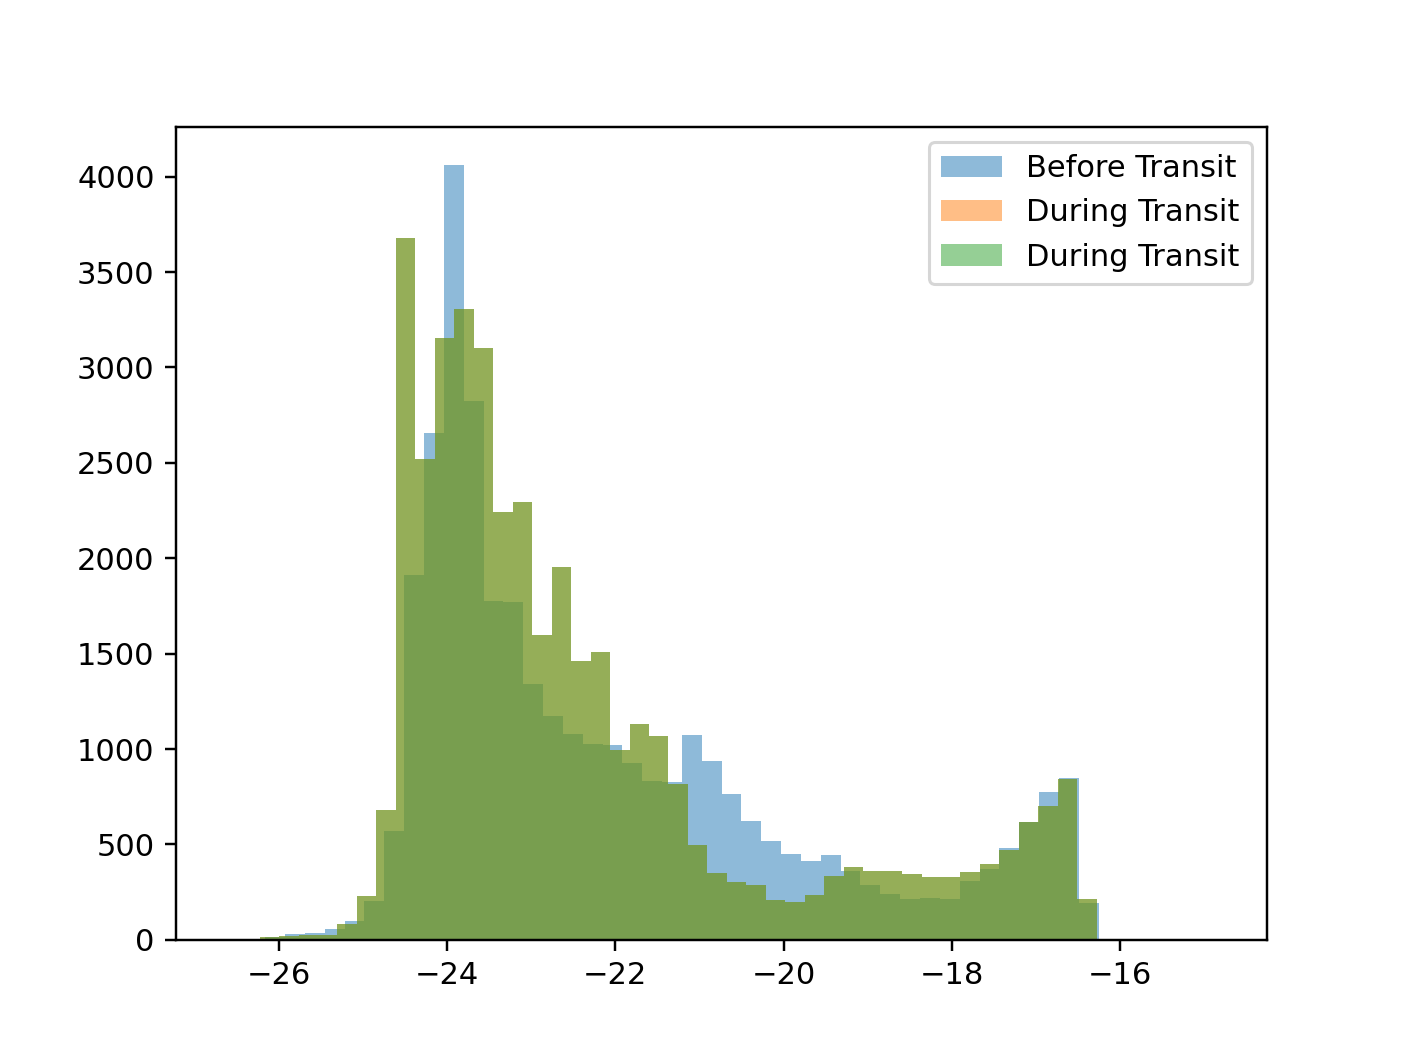

In [7]:
plt.figure()
data = full_data[:,:,40]
data = np.log10(data[data != 0.0])

data2 = full_data[:,:,0]
data2 = np.log10(data2[data2 != 0.0])

plt.hist(data2.flatten(), bins=50, alpha=0.5, label='Before Transit')

plt.hist(data.flatten(), bins=50, alpha=0.5, label='During Transit')

plt.hist(data.flatten(), bins=50, alpha=0.5, label='During Transit')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


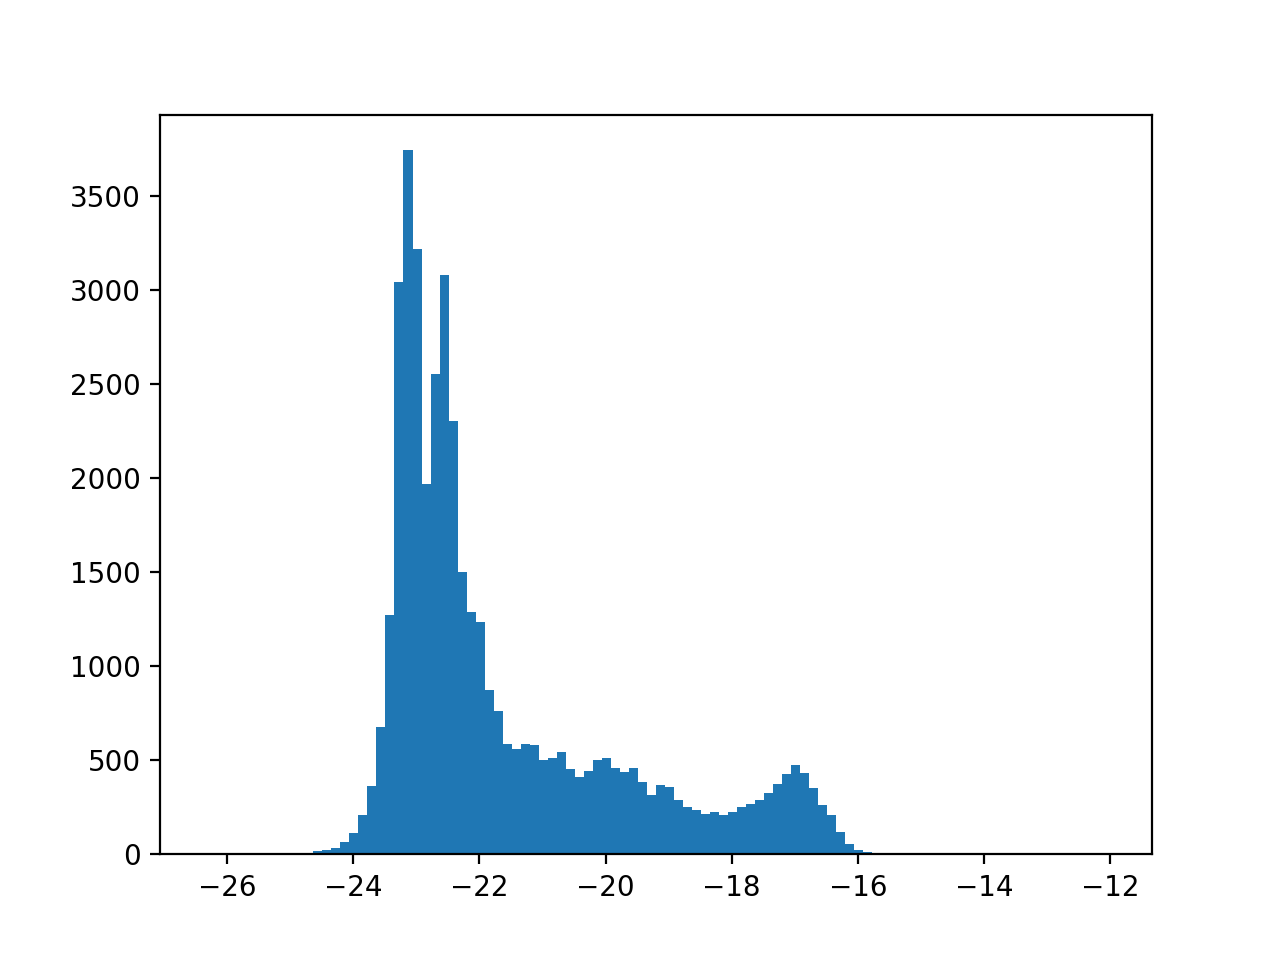

-12.05354397345643


In [9]:
plt.figure()
data = hd98800[:,:,90]
data = np.log10(data[data != 0.0])

plt.hist(data.flatten(), bins=100)
plt.show()

print(np.max(data))


      Ab        Bb   Aa        Ba
0    0.0  0.000031  0.0  0.000005
1    0.0  0.000031  0.0  0.000006
2    0.0  0.000031  0.0  0.000006
3    0.0  0.000031  0.0  0.000006
4    0.0  0.000029  0.0  0.000007
..   ...       ...  ...       ...
446  0.0  0.000142  0.0  0.000080
447  0.0  0.000144  0.0  0.000078
448  0.0  0.000123  0.0  0.000033
449  0.0  0.000100  0.0  0.000054
450  0.0  0.000101  0.0  0.000051

[451 rows x 4 columns]


/storage/astro1/phrkvg/env/lib64/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


<IPython.core.display.Javascript object>


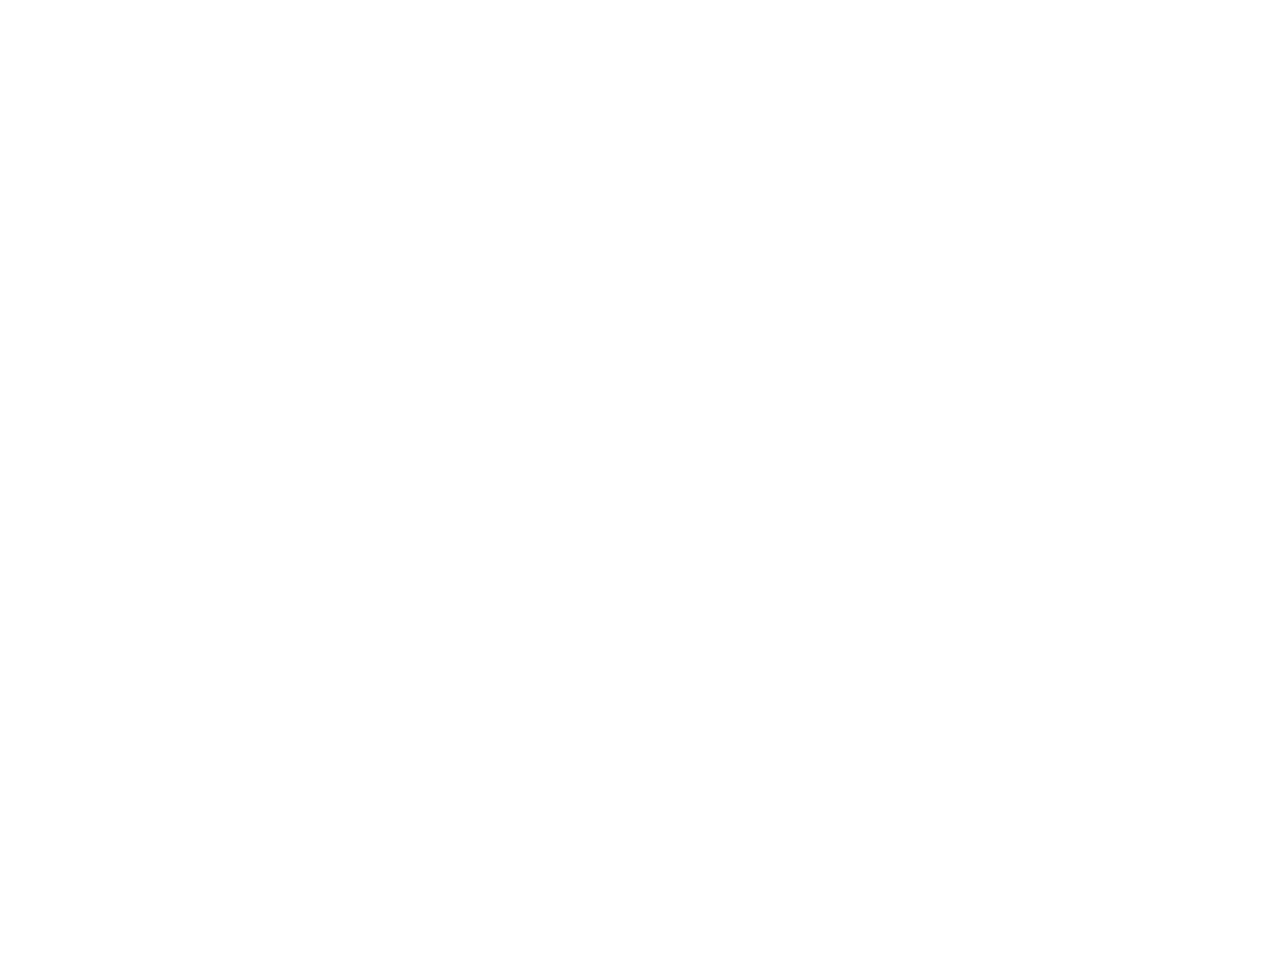

KeyError: '0'

In [10]:
import pandas as pd
taus = pd.read_csv('taus_highdt.txt', sep='  ', header=None, names=['Ab', 'Bb', 'Aa', 'Ba'])
print(taus)
fig = plt.figure()
Aa_taus = []
Ab_taus = []
Ba_taus = []
Bb_taus = []
times = []

start = 420*dt

for t in range(taus.shape[1]):
    times.append(start + t*dt/10)
    Ab_taus.append(taus['Ab'][t])
    Bb_taus.append(taus['Bb'][t])
    Aa_taus.append(taus['Aa'][t])
    Ba_taus.append(taus[''][t])

plt.plot(times, Aa_taus, 'r', label='Aa')
plt.plot(times, Ab_taus, 'b', label='Ab')
plt.plot(times, Ba_taus, 'g', label='Ba')
plt.plot(times, Bb_taus, 'y--', label='Bb')
plt.legend()
plt.xlabel('Time (yrs)')
plt.ylabel('$\\tau$ to star')


<IPython.core.display.Javascript object>


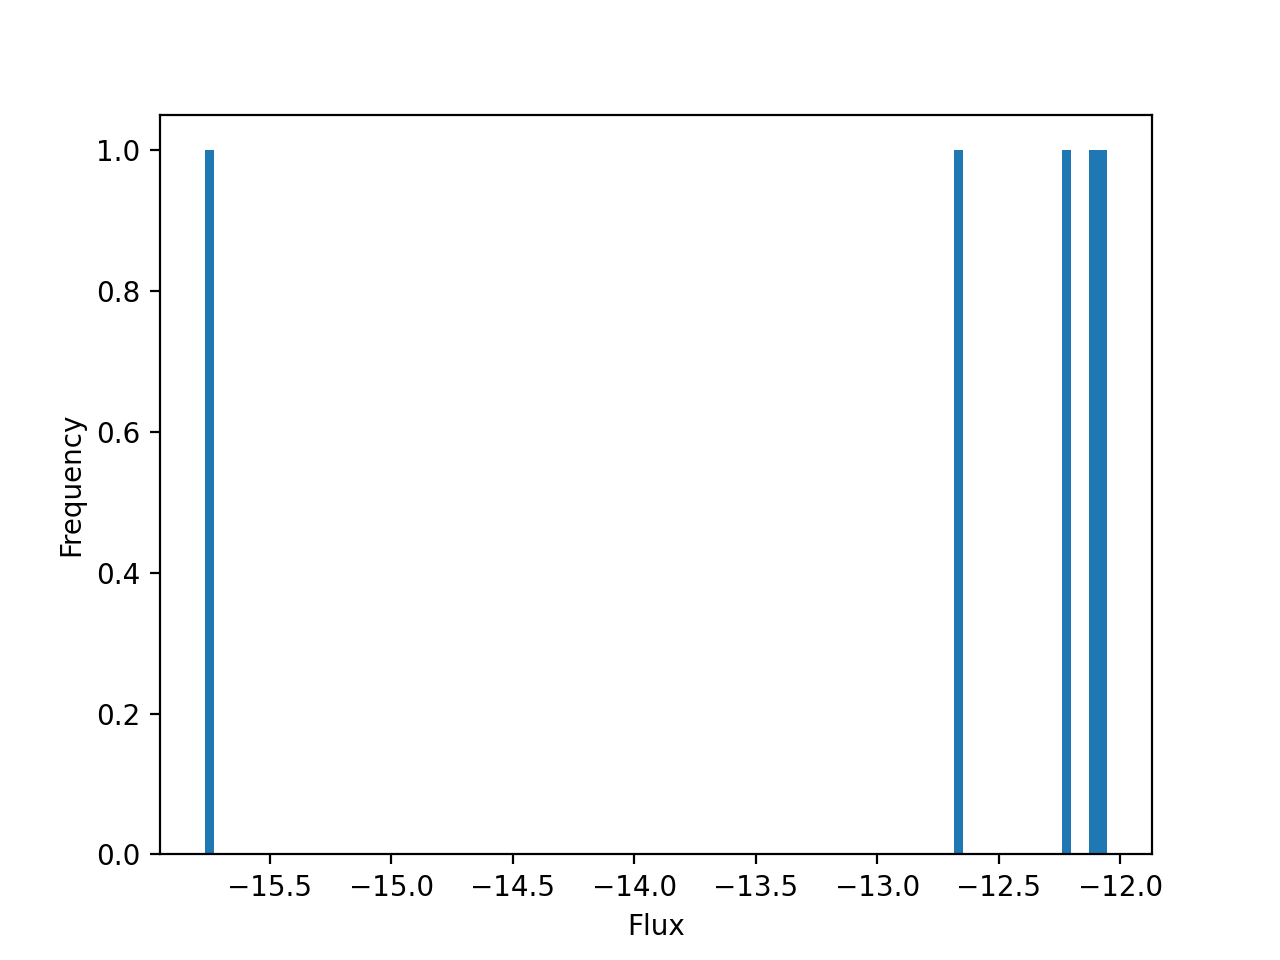

Text(0, 0.5, 'Frequency')

In [56]:
data = fits.open(f'./fits_1.6/RT_00438.fits.gz')[0].data
data2 = data[4, 0, 0, :, :]
data2 = np.log10(data2[data2 != 0.0])

fig = plt.figure()
plt.hist(data2.flatten(), bins=100)
plt.xlabel('Flux')
plt.ylabel('Frequency')


In [50]:
def plot_stellar_fluxes(dumpfiles, directory='./fits_1.6', start_time=400*dt):
    flux = np.zeros(len(dumpfiles))
    time = np.zeros(len(dumpfiles))
    for i, dumpfile in enumerate(dumpfiles):
        file_no = str(dumpfile).rjust(5, '0')
        pixel_data = fits.open(f'{directory}/RT_{file_no}.fits.gz')[0].data[4, 0, 0, :, :]
        flux[i] = np.sum(pixel_data)
        time[i] = i*dt + start_time
    
    fig = plt.figure()
    plt.plot(time,flux)
    plt.xlabel('Time  (yrs)')
    plt.ylabel('Flux')

<IPython.core.display.Javascript object>


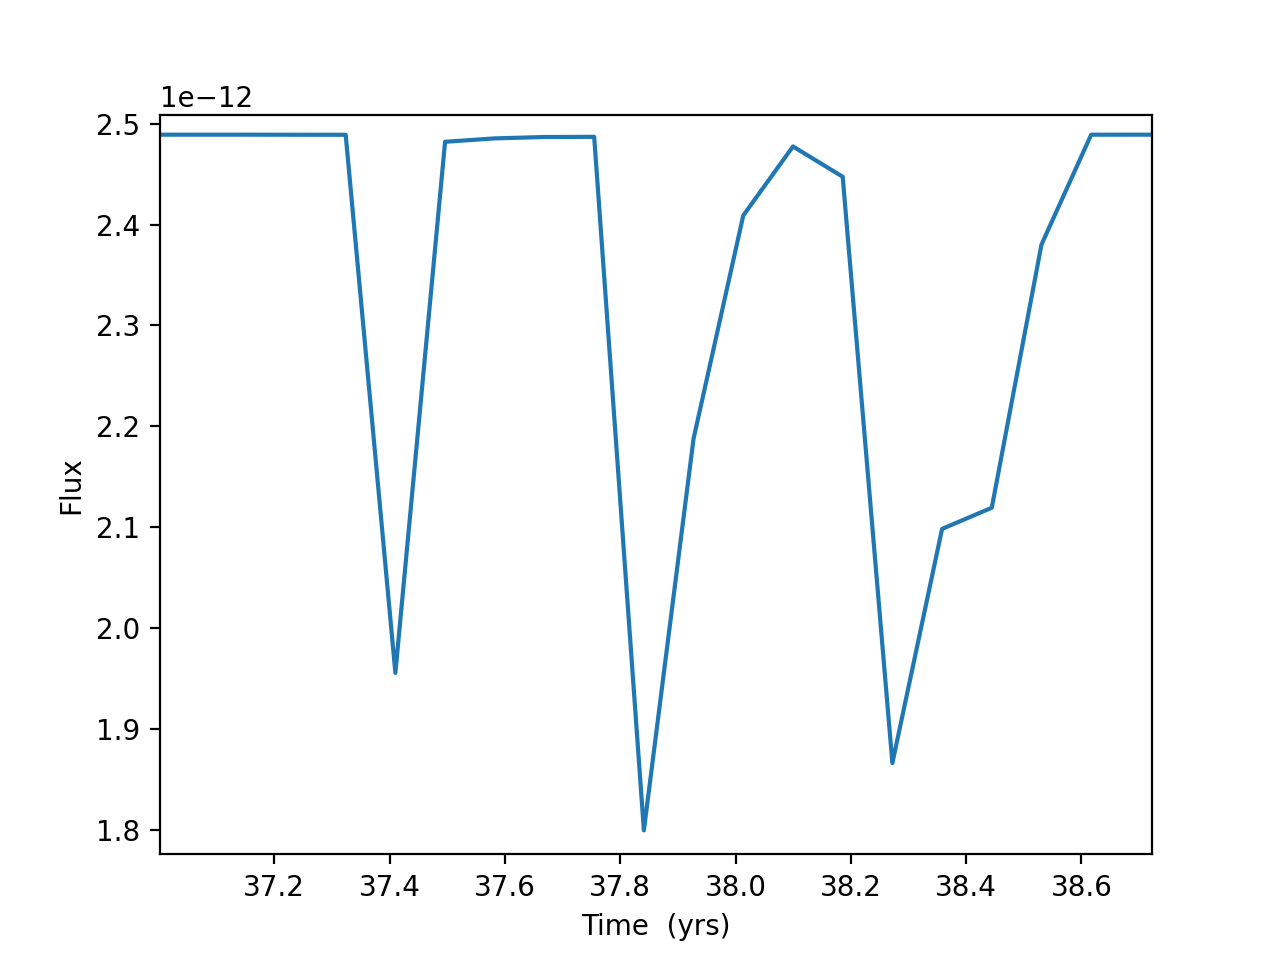

In [51]:
plot_stellar_fluxes(dumpfiles)

<IPython.core.display.Javascript object>


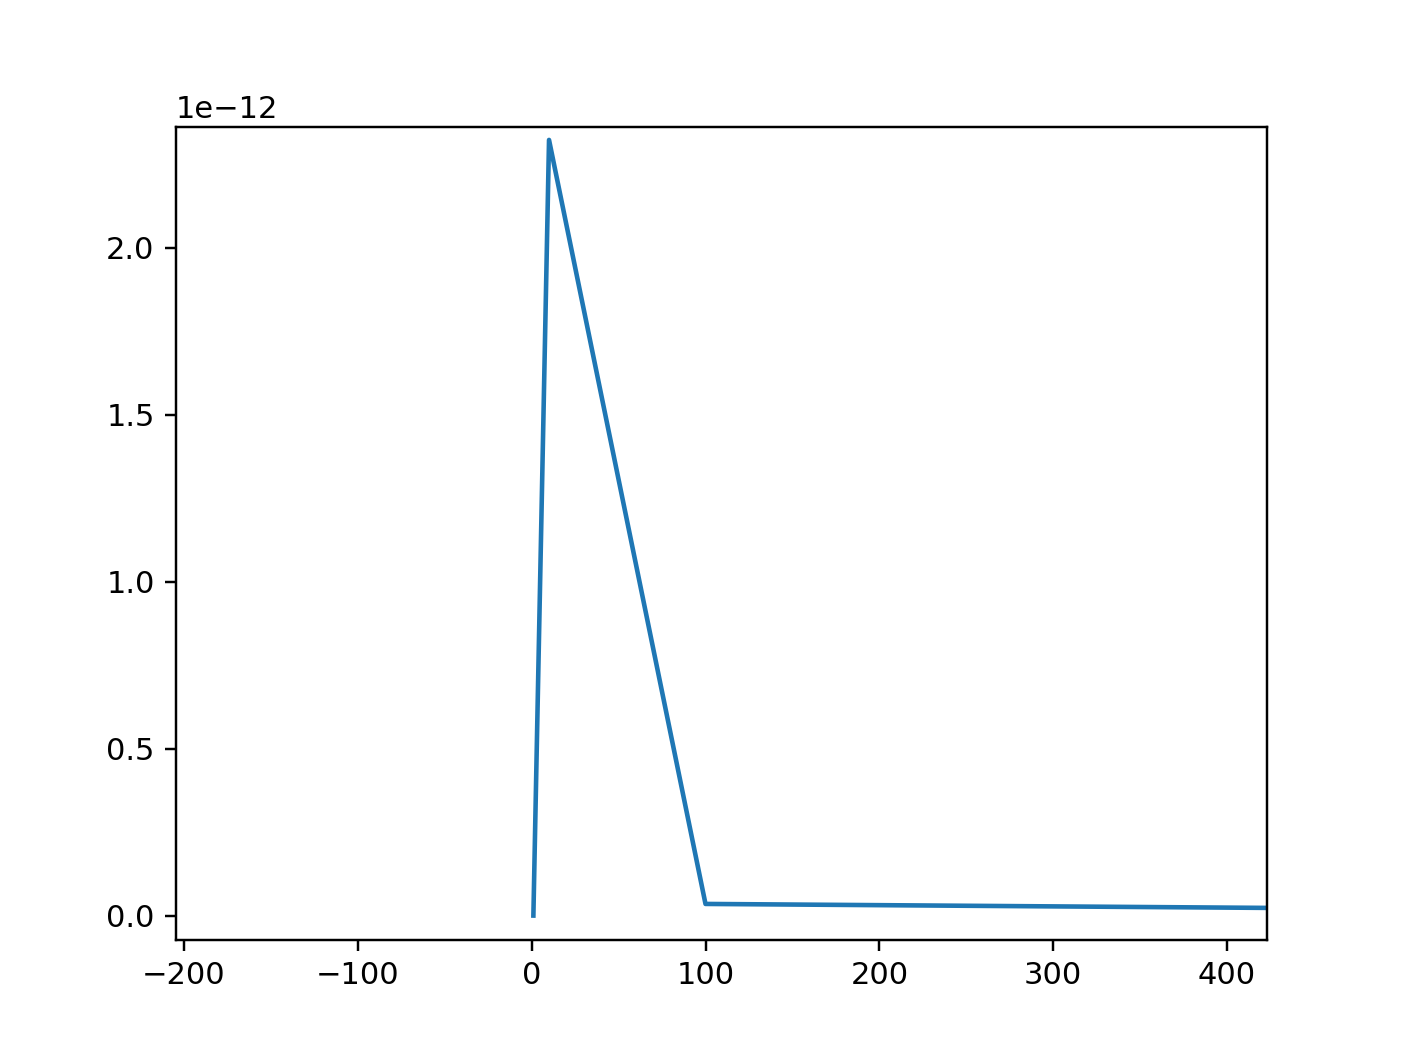

In [17]:
data.shape

(401, 401, 6)